In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

raw_loans = pd.read_csv('loan.csv', dtype={47: str}, low_memory=False)

# Use Seaborn's aesthetic
sns.set_theme()

# number of columns and rows
print("Number of columns: ", len(raw_loans.columns))
print("Number of rows: ", len(raw_loans))

Number of columns:  111
Number of rows:  39717


#### Remove unnecessary rows
- Remove loans that are still in progress

In [2]:
# remove loans that are still in progress
loans = raw_loans[raw_loans['loan_status'] != 'Current']

#### Clean up of columns
- Drop columns with all null values
- Drop columns with all same values

In [3]:
# Drop columns with all null values
nan_cols = loans.columns[loans.isna().all()].tolist()
print(len(nan_cols), "collumns have null values in all rows, these columns can be dropped")
loans = loans.drop(nan_cols, axis=1)

# Drop columns with only one unique value
unique_value_cols = loans.columns[loans.nunique() == 1]
print(len(unique_value_cols), "columns have only one unique value, these columns can be dropped as they do not provide any useful information")
loans = loans.drop(unique_value_cols, axis=1)

# Left with columns data
print("\n")
print("Columns left: ", len(loans.columns))

55 collumns have null values in all rows, these columns can be dropped
11 columns have only one unique value, these columns can be dropped as they do not provide any useful information


Columns left:  45


#### Remove outliers
Columns to remove outliers on:
 - loan_amnt
- funded_amnt
- annual_inc

In [4]:
raw_raw_count = len(raw_loans)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    return df.loc[filter]

# remove outliers
loans = remove_outliers(loans, 'loan_amnt')
loans = remove_outliers(loans, 'funded_amnt')
loans = remove_outliers(loans, 'annual_inc')

# calculate percentage of data removed
print("Percentage of data removed: ", round((1 - len(loans)/raw_raw_count) * 100, 2), "%")

Percentage of data removed:  10.11 %


#### Add new columns
- Add column for loan status (0 = not default, 100 = default)
- Add column for loan term (0 = 36 months, 1 = 60 months)
- Add column for loan grade (A-G)
- Add column for loan subgrade (1-5)
- Add column for loan home ownership (1-6)
- Add column for loan verification status (1-3)

- Add column for loan issue month (1-12)
- Add column for loan issue year (2007-2015)

- Add column for loan interest rate (0-30)

- Add column for percent funded (0-100)
- Add column for binning of percent funded (0-100)

- Add column for percent funded by investors (0-100)
- Add column for binning of percent funded by investors (0-100)

In [51]:
# add a new column to indicate if the loan is fully paid or not ( 0 - fully paid, 100 - defaulted)
# defaulted is set to 100 to make it easier to calculate the percentage of loans that are defaulted
loans['default'] = np.where(loans['loan_status'].isin(['Fully Paid']), 0, 100)

loans['term_num'] = loans['term'].apply(lambda x: int(x.split()[0]))

# convert issue_d to datetime
loans['issue_d'] = pd.to_datetime(loans['issue_d'], format='%b-%y')
loans['issue_month'] = loans['issue_d'].dt.month
loans['issue_year'] = loans['issue_d'].dt.year

# convert earliest_cr_line to datetime
loans['earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line'], format='%b-%y')

# convert last_pymnt_d to datetime
loans['last_pymnt_d'] = pd.to_datetime(loans['last_pymnt_d'], format='%b-%y')

# convert last_credit_pull_d to datetime
loans['last_credit_pull_d'] = pd.to_datetime(loans['last_credit_pull_d'], format='%b-%y')

# convert loan grade to numeric
loans['grade_num'] = loans['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

# convert loan sub grade to numeric
loans['sub_grade_num'] = loans['sub_grade'].map({'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                                                    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                                                    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                                                    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                                                    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                                                    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                                                    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35})

# convert loan sub grade to numeric
loans['emp_length_num'] = loans['emp_length'].map({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                                                    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
                                                    '10+ years': 10})

# convert loan grade and sub grade to combined numeric
loans['grade_sub_grade_num'] = loans['grade_num'] * 100 + loans['sub_grade_num'] * 20

# convert int_rate to numeric
loans['int_rate_num'] = loans['int_rate'].str.rstrip('%').astype('float')

# convert revol_util to numeric
loans['revol_util_num'] = loans['revol_util'].str.rstrip('%').astype('float')

In [6]:
loans = remove_outliers(loans, 'int_rate_num')

In [7]:
import numpy_financial as npf

def calc_interest_rate(row):
    return (npf.rate(row['term_num'], row['installment'], -row['funded_amnt'], 0) * 12 * 100).round(2)

loans['total_amount_to_pay'] = loans['installment'] * loans['term_num']
loans['total_interest'] = loans['total_amount_to_pay'] - loans['funded_amnt']
loans['total_loss'] = loans.apply(lambda x: (x['total_pymnt'] - x['total_amount_to_pay']) if x['default'] == 100 else 0, axis=1)
loans['loss_percentage'] = (loans['total_loss'] / loans['total_amount_to_pay'] * 100).abs().round(2)

loans['calc_interest_rate'] = loans.apply(calc_interest_rate, axis=1)

## High level information

In [8]:
# average default rate
print("Average default rate: ", (loans['default'].mean()).round(1), "%")

Average default rate:  14.5 %


In [9]:
# avg loss percentage for defaulted loans
print("Average loss percentage for defaulted loans: ", (loans['loss_percentage'].mean()).round(2), '%')

# total funded loan amount
total_funded_amount = loans['funded_amnt'].sum()
print("Total funded loan amount: ", f"{total_funded_amount.round(0):,}", "$")

# total recovered amount
total_recovered_amount = loans['total_pymnt'].sum()
print("Total recovered amount: ", f"{total_recovered_amount.round(0):,}", "$")

loans['profit'] = loans['total_pymnt'] - loans['funded_amnt']

Average loss percentage for defaulted loans:  8.0 %
Total funded loan amount:  352,272,125 $
Total recovered amount:  386,223,270.0 $


# Understanding the data

To confirm the understanding of the loan amount and interest rate, the following check is made:
```
Check if the calculated interest rate on total amount to pay (installment * term) is equal to the provided interest rate within a reasonable margin of error (0.1%)
The margin of error could arise by different interest calculation methods, and rounding
```

only 10 rows seem to be not correct, this could happen due to mid term changes in interest rate or any other reason. The rows are removed from the dataset.

In [10]:
# print rows where calc_interest_rate is not equal to int_rate within 0.1% tolerance
print("Number of loans that are not within the tolerance", len(loans[(loans['calc_interest_rate'] - loans['int_rate_num']).abs() > 0.1]))

# drop rows where calc_interest_rate is not equal to int_rate within 0.1% tolerance
loans = loans[(loans['calc_interest_rate'] - loans['int_rate_num']).abs() <= 0.1]

Number of loans that are not within the tolerance 10


In [11]:
# show all columns with null values
print("Columns with null values: ")
print(loans.isnull().sum()[loans.isnull().sum() > 0])

Columns with null values: 
emp_title                  2147
emp_length                  998
desc                      11523
title                        11
mths_since_last_delinq    23015
mths_since_last_record    33022
revol_util                   48
last_pymnt_d                 69
last_credit_pull_d            2
pub_rec_bankruptcies        657
emp_length_num              998
revol_util_num               48
dtype: int64


# Data analysis
Finding relation of default rate with different variables

### Default rate by year and months (inconclusive)

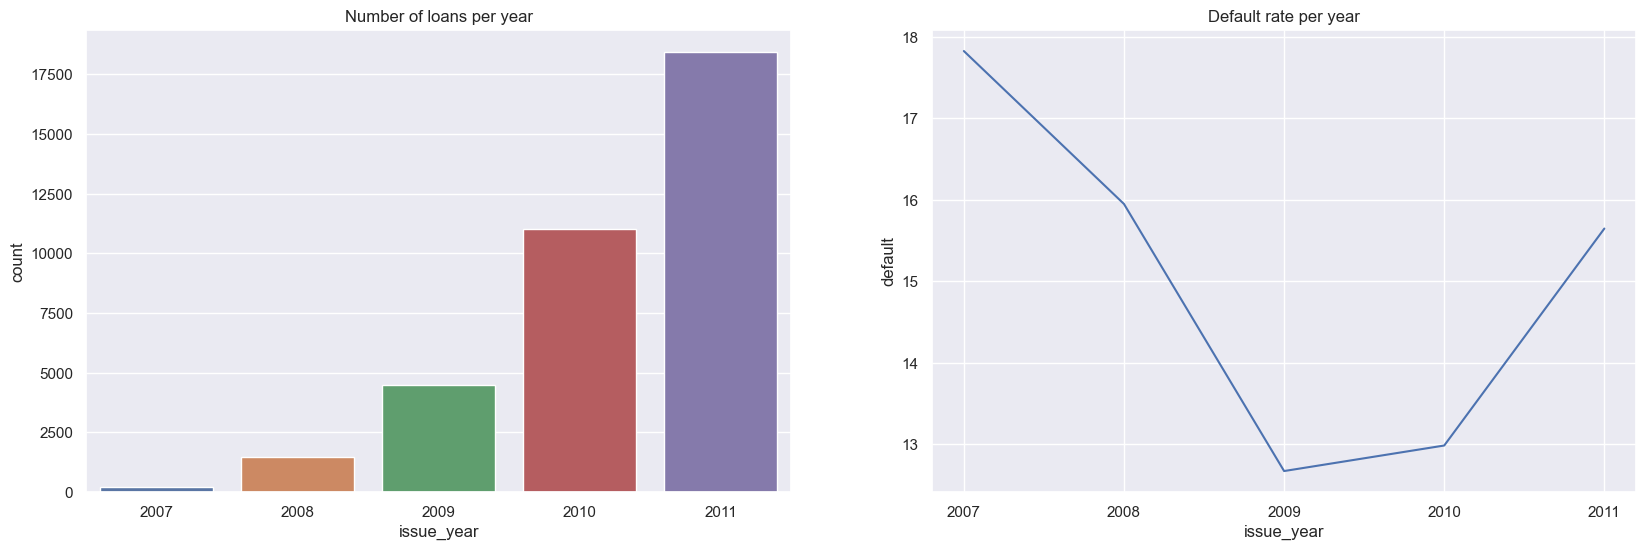

<Figure size 1200x600 with 0 Axes>

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# number of loans per year
sns.countplot(x='issue_year', data=loans, ax=ax1)
ax1.set_title('Number of loans per year')


# draw line chart of defaulted loans percentage per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_year', y='default', data=df, ax=ax2)
ax2.set_xticks(df['issue_year'])
ax2.set_title('Default rate per year')

plt.show()

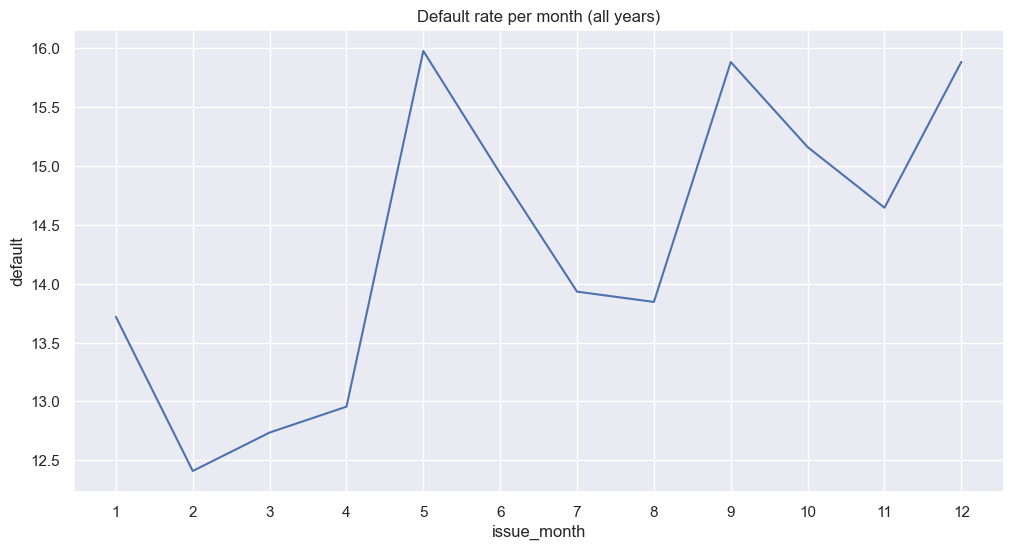

In [14]:
# draw line chart of defaulted loans percentage per month
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', data=df)
plt.xticks(df['issue_month'])
plt.title('Default rate per month (all years)')
plt.show()

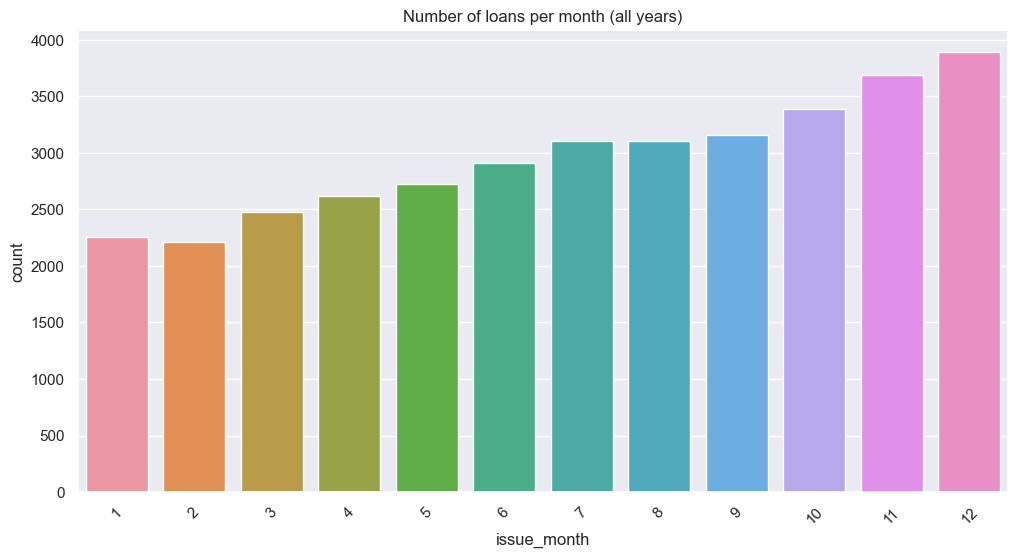

In [113]:
# plot number of loans per month
plt.figure(figsize=(12, 6))

sns.countplot(x='issue_month', data=loans)
plt.xticks(rotation=45)
plt.title('Number of loans per month (all years)')
plt.show()

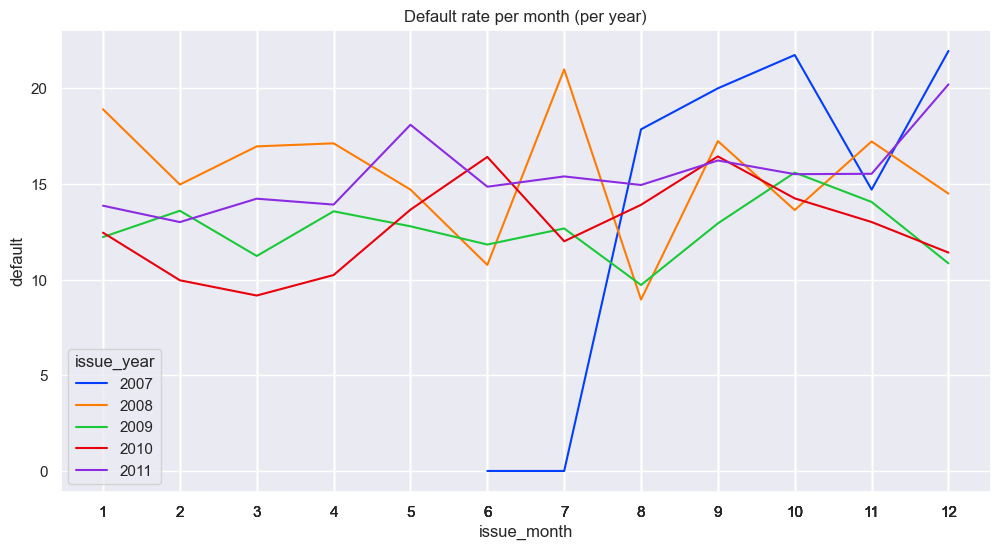

In [16]:
# draw line chart of defaulted loans percentage per month per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year', 'issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', hue='issue_year', data=df, palette='bright', legend='full')
plt.xticks(df['issue_month'])
plt.title('Default rate per month (per year)')
plt.show()

### Default rate by grade and subgrade (not relevant)

Grade is assigned by lending club based on the credit score of the borrower. The subgrade is a more granular classification of the grade. The default rate is higher for lower grades and subgrades.
So interest rate is higher for lower grades and subgrades.

Lending club is giving more loans to better grades.

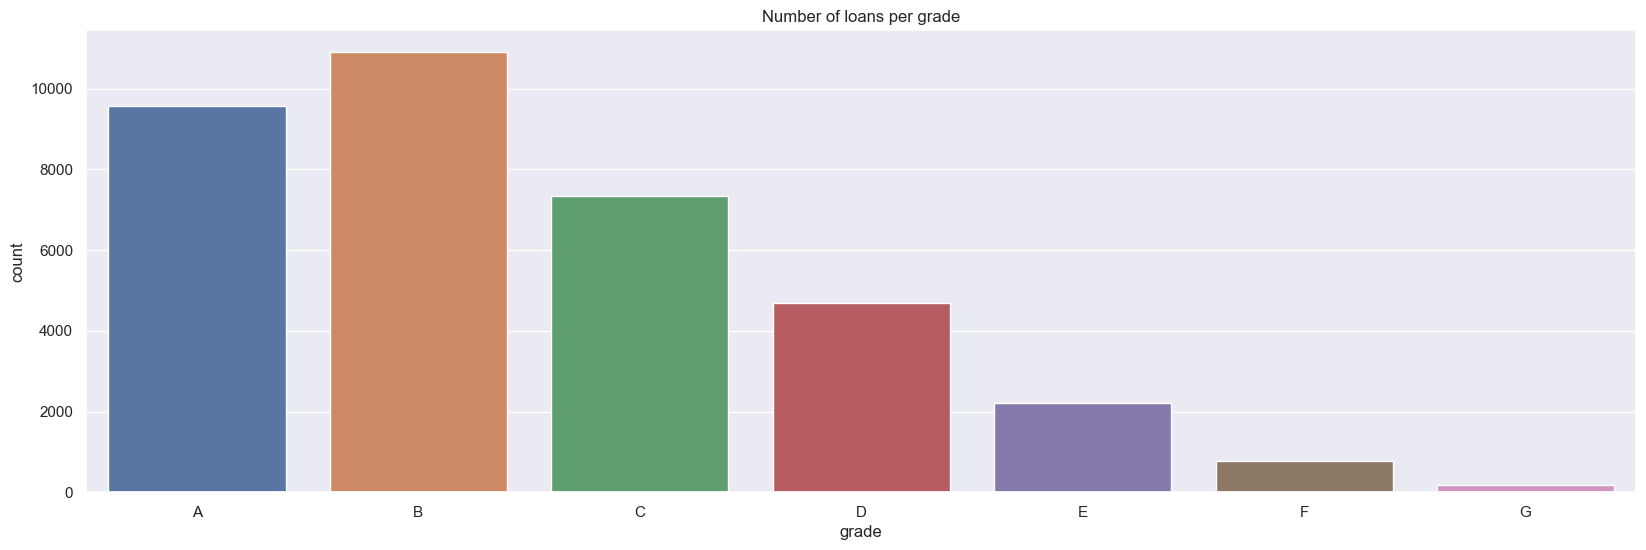

In [17]:
# plot number of loans per grade
plt.figure(figsize=(20, 6))
sns.countplot(x='grade', data=loans, order=sorted(loans['grade'].unique()))
plt.title('Number of loans per grade')
plt.show()

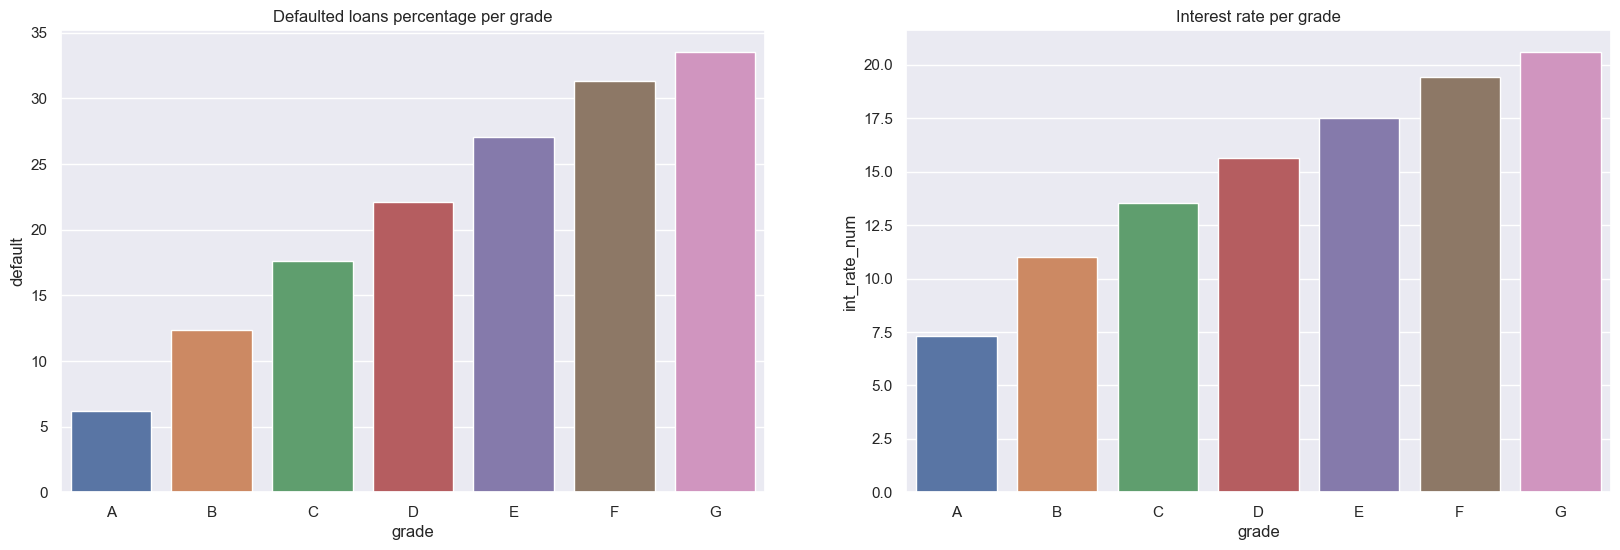

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw line chart of defaulted loans percentage per grade
default_rate = loans.groupby(['grade']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='grade', y='default', data=default_rate, ax=ax1)
ax1.set_title('Defaulted loans percentage per grade')

# draw interest rate per grade
interest_rate = loans.groupby(['grade']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='grade', y='int_rate_num', data=interest_rate, ax=ax2)
ax2.set_title('Interest rate per grade')

plt.show()

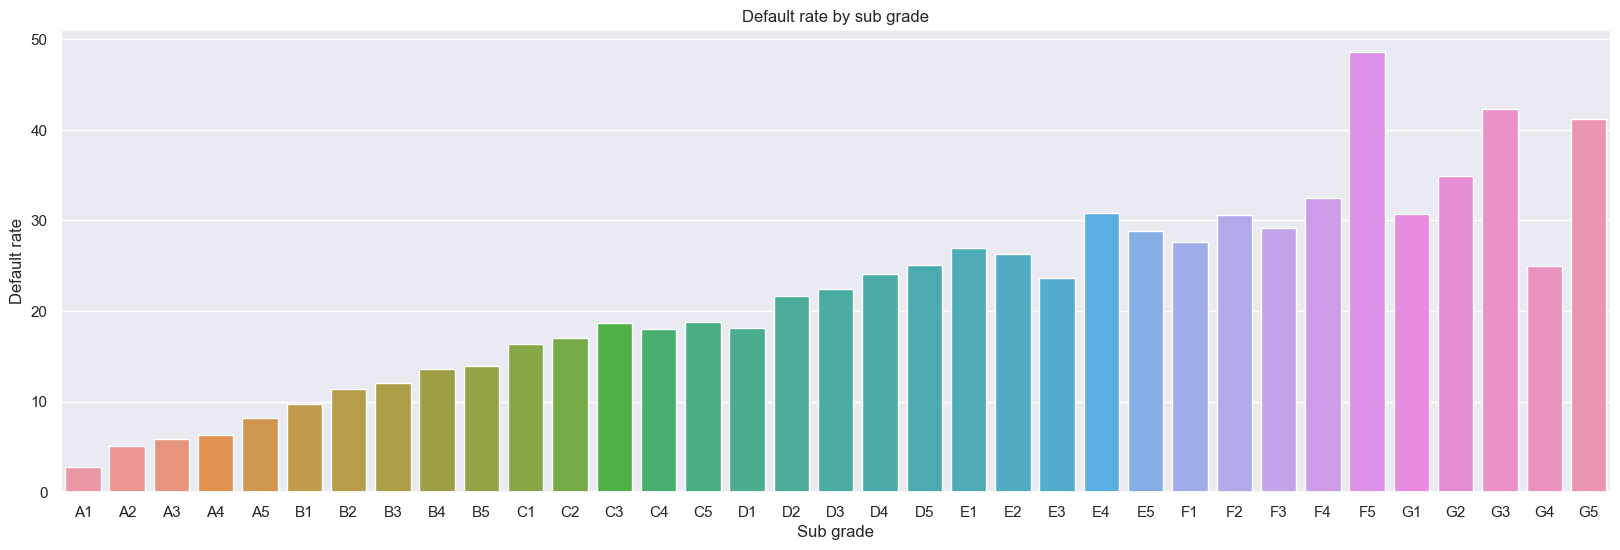

In [115]:
# plot default rate by sub grade
plt.figure(figsize=(20, 6))
default_rate_sub_grade = loans[['sub_grade', 'default']].copy()
default_rate_sub_grade = default_rate_sub_grade.groupby(['sub_grade']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='sub_grade', y='default', data=default_rate_sub_grade)
plt.title('Default rate by sub grade')
plt.xlabel('Sub grade')
plt.ylabel('Default rate')
plt.show()

### Default rate by term size (huge impact)

There are 2 term sizes 36 and 60 months. The default rate is higher for 60 months term size by 2 times, this also reflects in the interest rate.

Although the number of loans given for 60 months term size is less than a quarter of the total loans, the default loans count is 40% of the total default loans.
While the 60 month term loans constitute 30% of the total funds, the loss brought in by these loans is almost 60% of the total loss.

This could be due to the fact that the borrower is more likely to default if the loan is longer, as the borrower is more likely to have a change in financial situation.

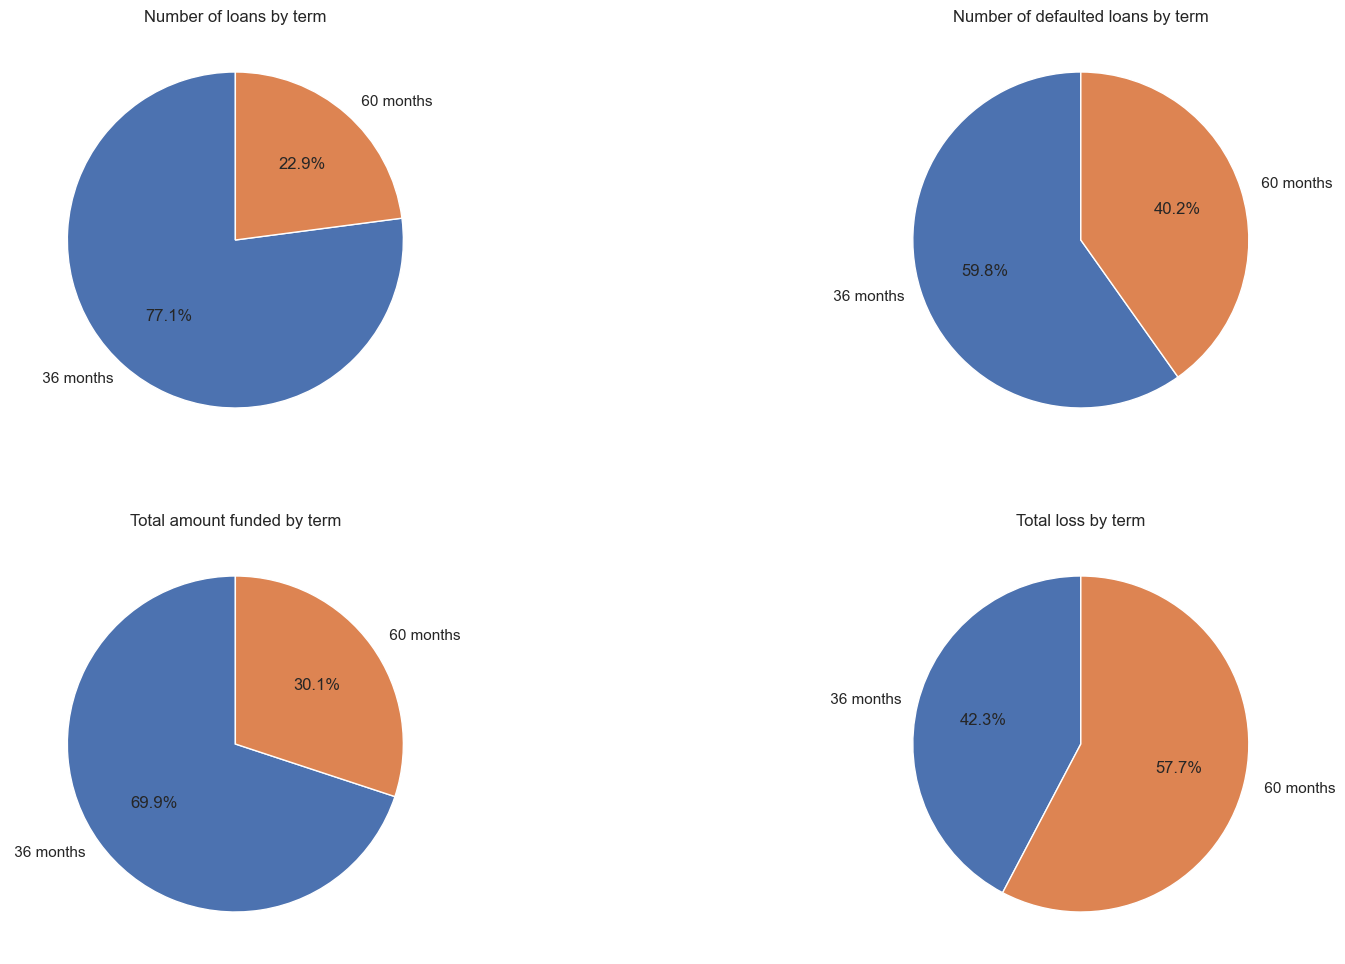

In [21]:
fig, plots = plt.subplots(2, 2, figsize=(20, 12))

# draw pie chart of number of loans by term
term = loans.groupby(['term']).agg({'id': 'count'}).reset_index()
plots[0, 0].pie(term['id'], labels=term['term'], autopct='%1.1f%%', startangle=90)
plots[0, 0].set_title('Number of loans by term')

# draw pie chart of number of defaulted loans by term
defaulted_loans = loans[loans['default'] != 0]
defaulted_loans = defaulted_loans.groupby(['term']).agg({'id': 'count'}).reset_index()
plots[0, 1].pie(defaulted_loans['id'], labels=defaulted_loans['term'], autopct='%1.1f%%', startangle=90)
plots[0, 1].set_title('Number of defaulted loans by term')

# total amount funded by term
total_amount_funded = loans.groupby(['term']).agg({'funded_amnt': 'sum'}).reset_index()
plots[1, 0].pie(total_amount_funded['funded_amnt'], labels=total_amount_funded['term'], autopct='%1.1f%%', startangle=90)
plots[1, 0].set_title('Total amount funded by term')

# total loss by term
total_loss = loans.groupby(['term']).agg({'total_loss': 'sum'}).reset_index()
total_loss['total_loss'] = total_loss['total_loss'].abs()
plots[1, 1].pie(total_loss['total_loss'], labels=total_loss['term'], autopct='%1.1f%%', startangle=90)
plots[1, 1].set_title('Total loss by term')

plt.show()

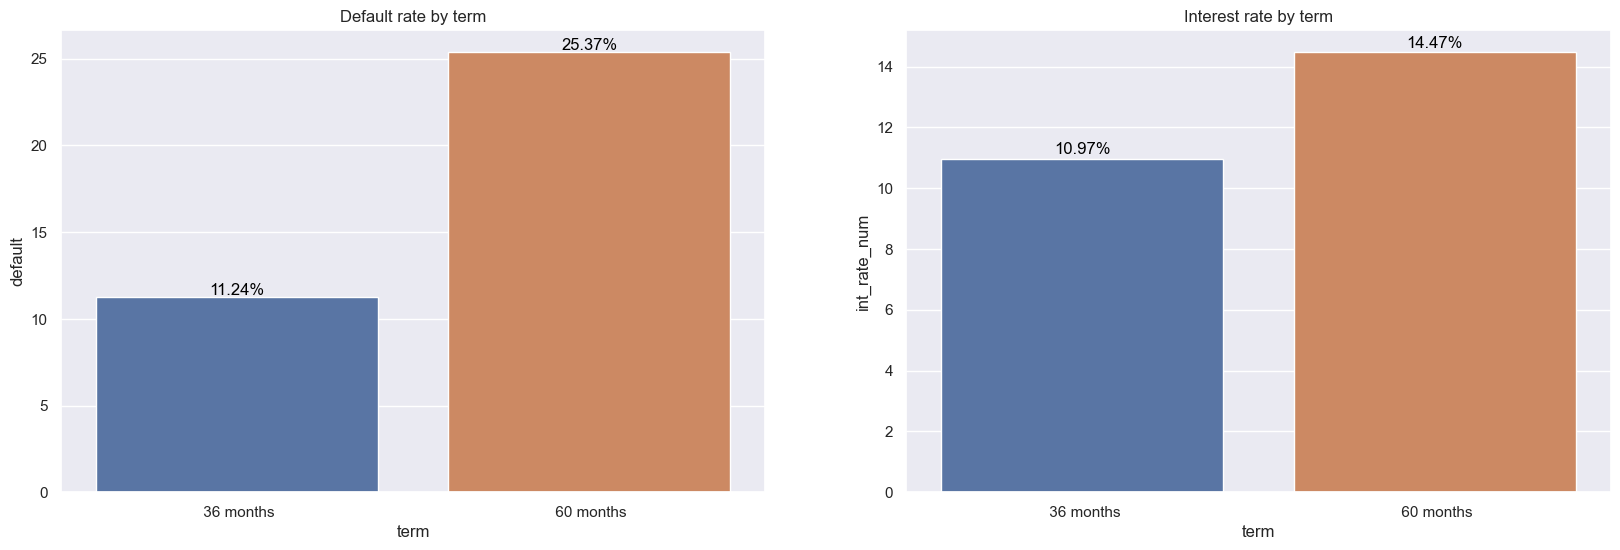

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# plot default rate by term
default_rate = loans.groupby(['term']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='term', y='default', data=default_rate, ax=ax1)

# show values on top of bars
for index, row in default_rate.iterrows():
    ax1.text(row.name, row.default + 0.15, str(round(row.default, 2)) + '%', color='black', ha="center")
ax1.set_title('Default rate by term')

# plot interest rate by term
interest_rate = loans.groupby(['term']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='term', y='int_rate_num', data=interest_rate, ax=ax2)

# show values on top of bars
for index, row in interest_rate.iterrows():
    ax2.text(row.name, row.int_rate_num + 0.15, str(round(row.int_rate_num, 2)) + '%', color='black', ha="center")
ax2.set_title('Interest rate by term')

plt.show()

### Default rate by purpose (some impact)

Most of the loans on the platform are for debt consolidation.

Small businesses, renewable energy and education have the highest default rate (15% - 20%)
Car, credit card, major puchase and wedding have the lowest default rate (about 10%)

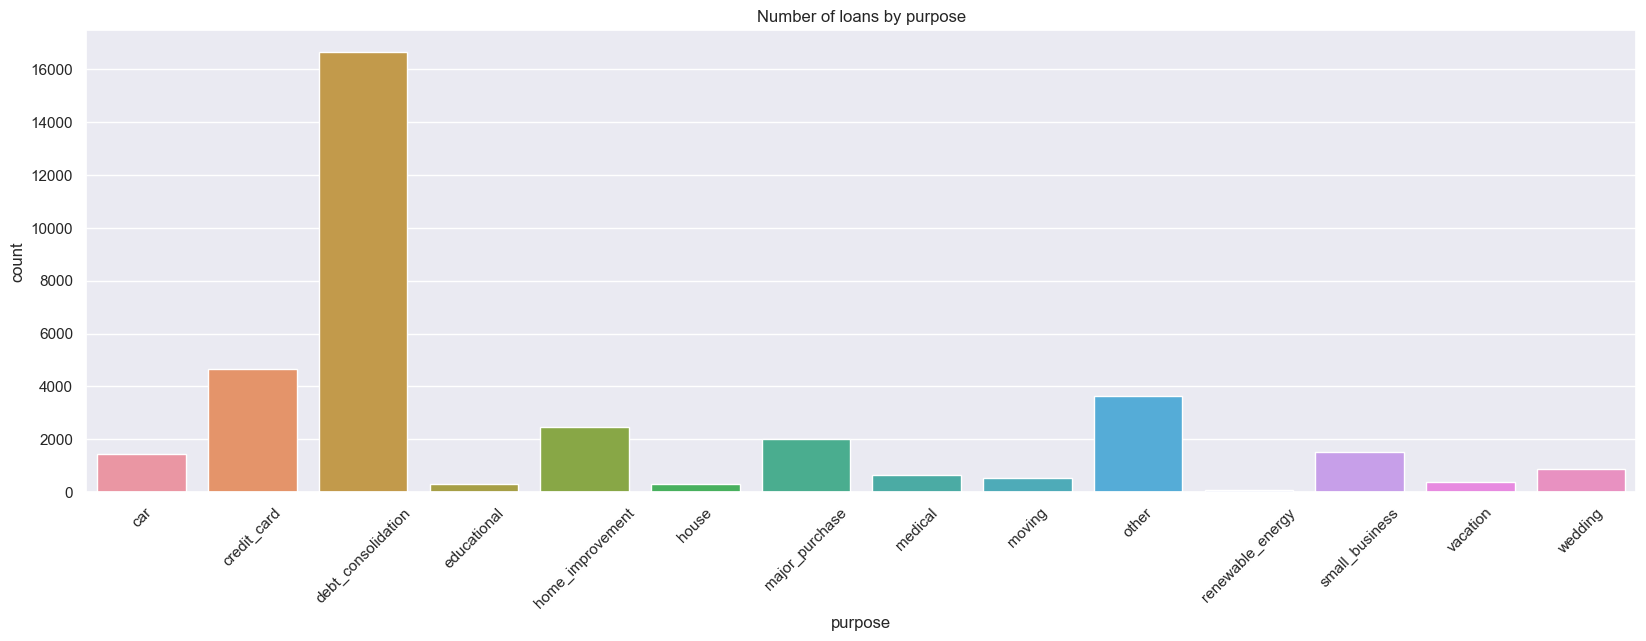

In [127]:
# plot pie chart of number of loans by purpose
plt.figure(figsize=(20, 6))
sns.countplot(x='purpose', data=loans, order=sorted(loans['purpose'].unique()))
plt.title('Number of loans by purpose')
plt.xticks(rotation=45)
plt.show()

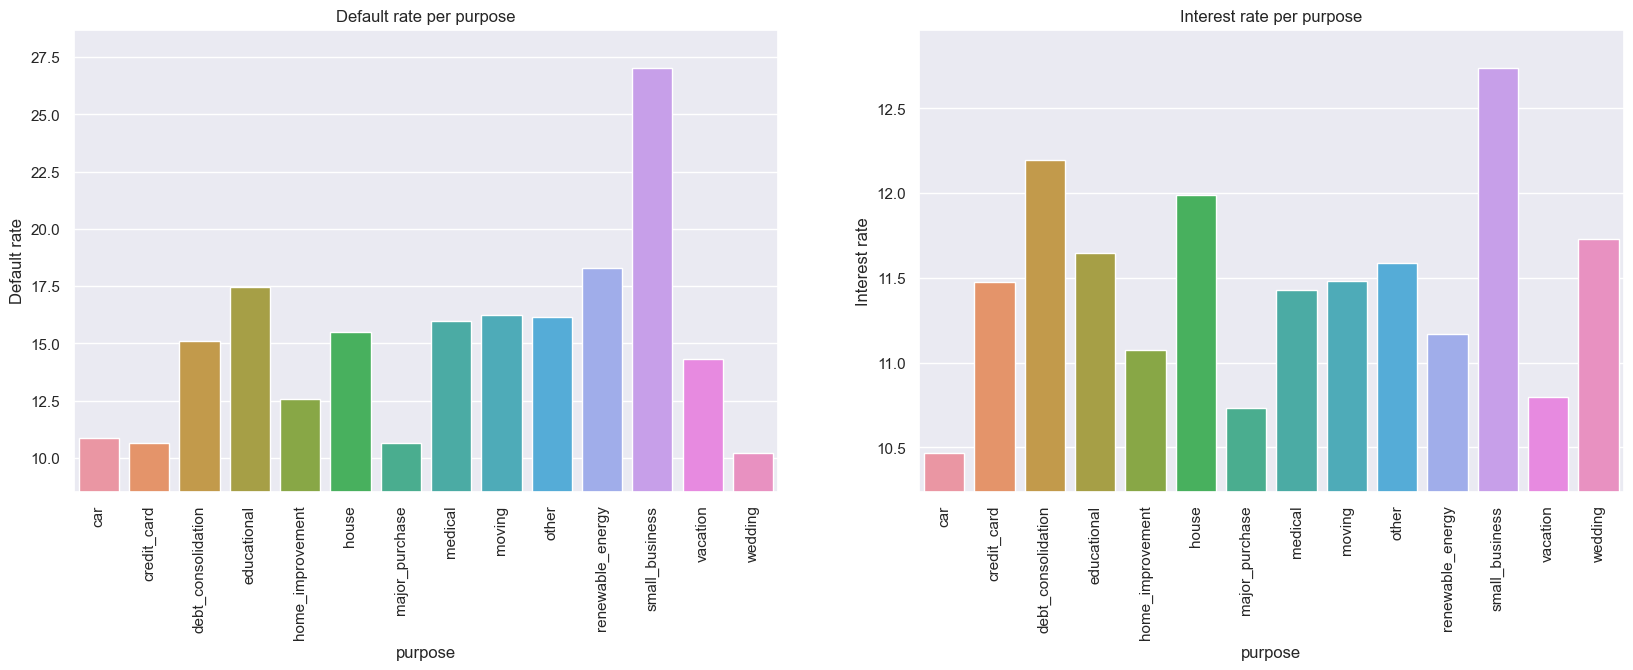

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# draw loan default percentage per purpose
default_rate = loans.groupby(['purpose']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='purpose', y='default', data=default_rate, ax=ax1)

# Get the minimum and maximum values
min_val = default_rate['default'].min()
max_val = default_rate['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
ax1.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Default rate per purpose')
ax1.set_ylabel('Default rate')

# draw interest rate per purpose
interest_rate = loans.groupby(['purpose']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='purpose', y='int_rate_num', data=interest_rate, ax=ax2)

# Get the minimum and maximum values
min_val = interest_rate['int_rate_num'].min()
max_val = interest_rate['int_rate_num'].max()

# Set the limits of y-axis to be slightly beyond the min and max
ax2.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Interest rate per purpose')
ax2.set_ylabel('Interest rate')

plt.show()

### Default rate by home ownership (no impact)

home_ownership
RENT        17721
MORTGAGE    15027
OWN          2792
Name: count, dtype: int64


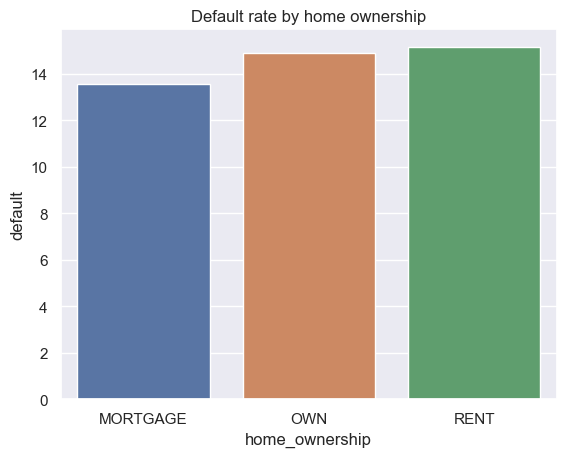

In [136]:
print(loans['home_ownership'].value_counts())

# ignore NONE and OTHERS as they are very few
loans = loans[loans['home_ownership'] != 'NONE']
loans = loans[loans['home_ownership'] != 'OTHER']

# plot default rate by home ownership
default_rate = loans.groupby(['home_ownership']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='home_ownership', y='default', data=default_rate)
plt.title('Default rate by home ownership')
plt.show()

### Default rate by income (good impact)

Default rate is higher for lower income groups because they are more likely to default due to their financial situation.

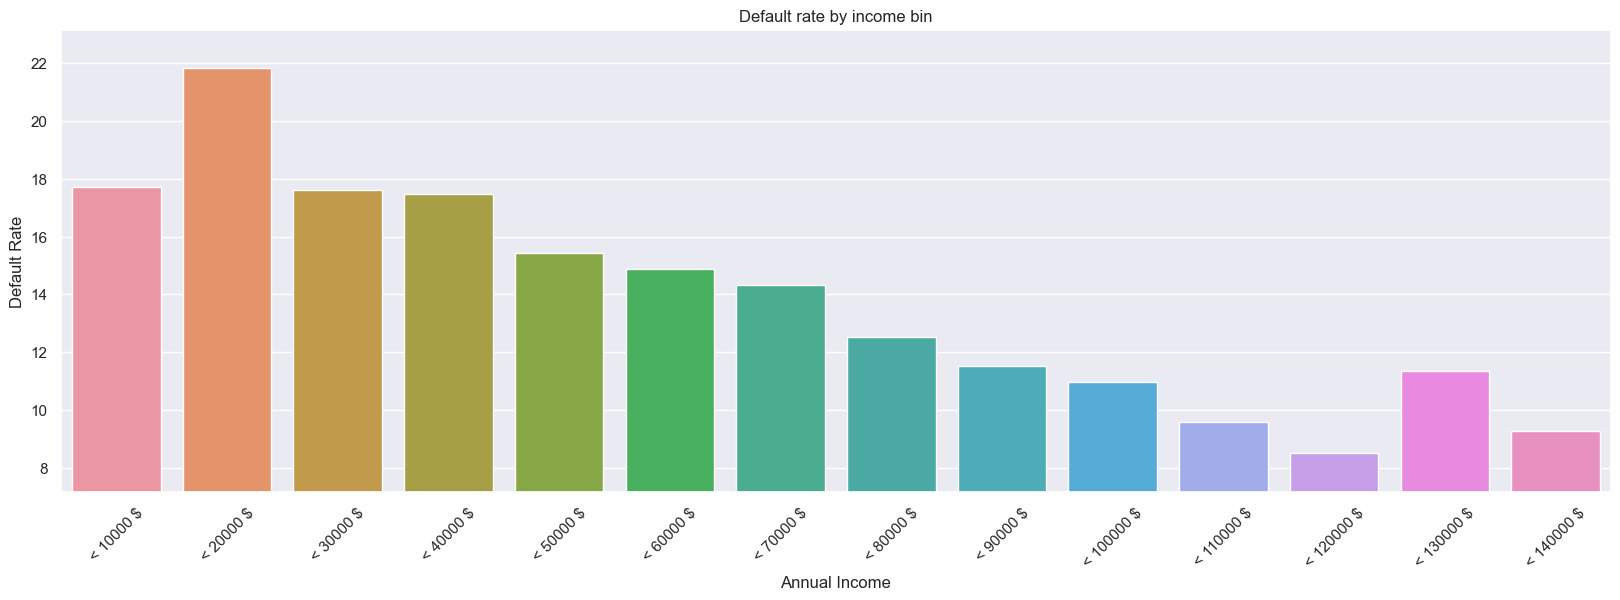

In [137]:
plt.figure(figsize=(20, 6))

# Copy the DataFrame to avoid SettingWithCopyWarning
default_rate_income = loans[['loan_status', 'annual_inc', 'default']].copy()

# Define user-friendly bin edges
bin_edges = range(0, int(default_rate_income['annual_inc'].max() + 10000), 10000)
default_rate_income['income_bin'] = pd.cut(default_rate_income['annual_inc'], bins=bin_edges, include_lowest=True, right=False)

default_rate_income = default_rate_income.groupby(['income_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='income_bin', y='default', data=default_rate_income)

# Get the minimum and maximum values from your data
min_val = default_rate_income['default'].min()
max_val = default_rate_income['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_income['income_bin']], rotation=45)
plt.xlabel('Annual Income')
plt.ylabel('Default Rate')
plt.title('Default rate by income bin')
plt.show()

### Default rate by state (some impact)

Lending club is heavily used in California, Texas, New York and Florida.

Florida has the highest default rate (more than 17.5%) while Texas has the lowest default rate (less than 12%)

But the interest rate is not higher for states with higher default rate.

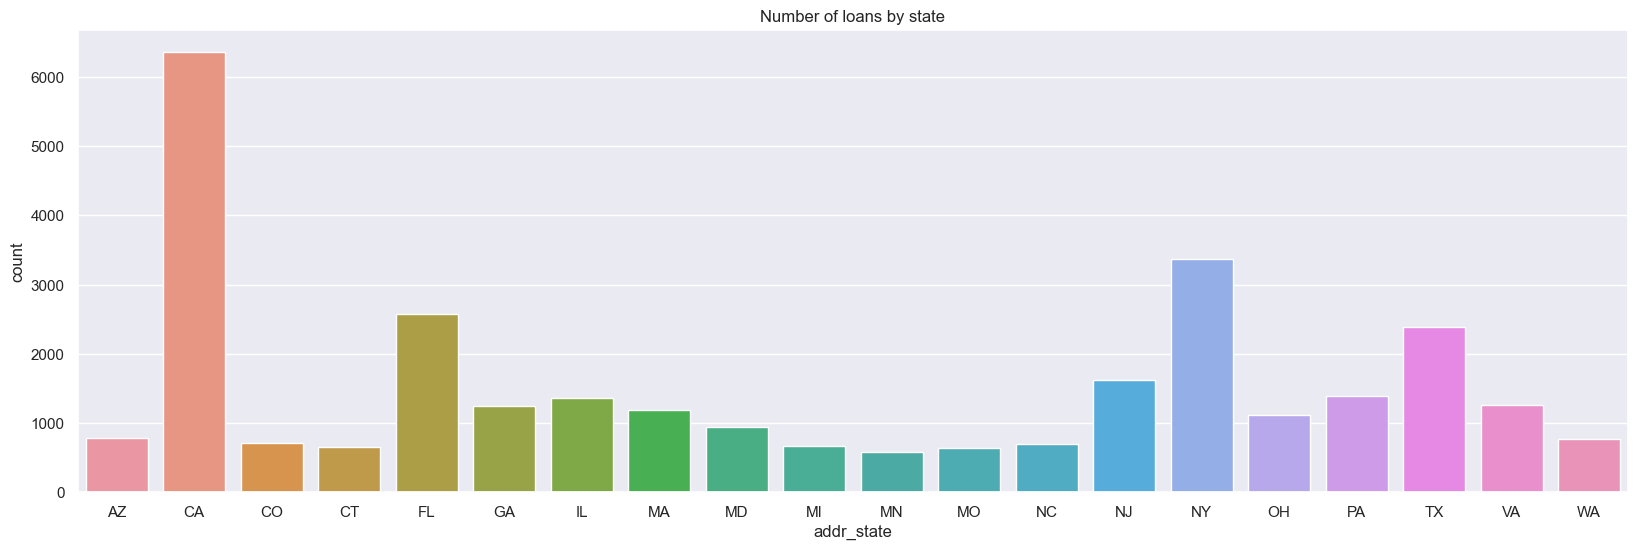

In [105]:
# plot number of loans by state
plt.figure(figsize=(20, 6))

loans_per_State = loans[['addr_state', 'default']].copy()

# ignore states with less than 100 loans
loans_per_State = loans_per_State.groupby(['addr_state']).filter(lambda x: len(x) > 500)

sns.countplot(x='addr_state', data=loans_per_State, order=sorted(loans_per_State['addr_state'].unique()))
plt.title('Number of loans by state')
plt.show()

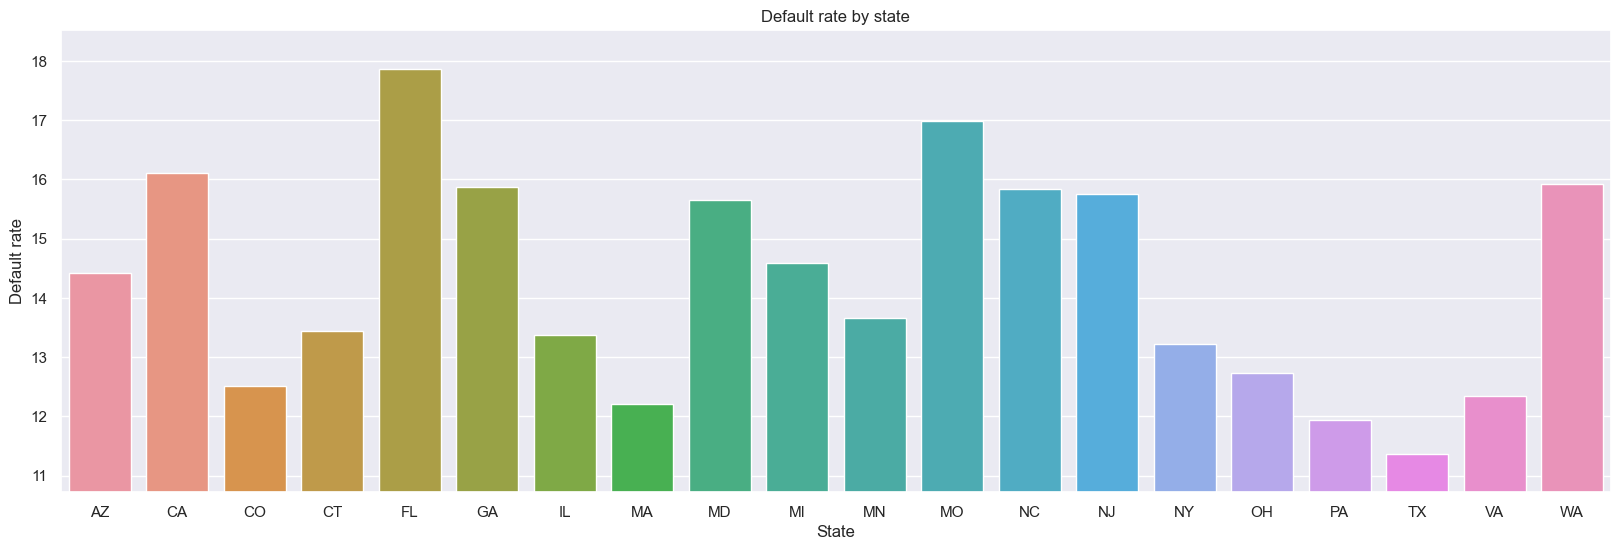

In [111]:
# show the default rate in each state
plt.figure(figsize=(20, 6))

loans_per_State = loans_per_State.groupby(['addr_state']).agg({'default': 'mean'}).reset_index()

ax = sns.barplot(x='addr_state', y='default', data=loans_per_State)

# Get the minimum and maximum values from your data
min_val = loans_per_State['default'].min()
max_val = loans_per_State['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
ax.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by state')
plt.xlabel('State')
plt.ylabel('Default rate')
plt.show()

In [99]:
fig = px.choropleth(loans_per_State, locations='addr_state', color='default',
                    locationmode='USA-states', scope="usa",
                    title='Defaulters rate by State',
                    color_continuous_scale=px.colors.sequential.Reds,
                    labels={'percentage': 'Percentage of Defaulters'},
                    )
fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 10})
fig.show()

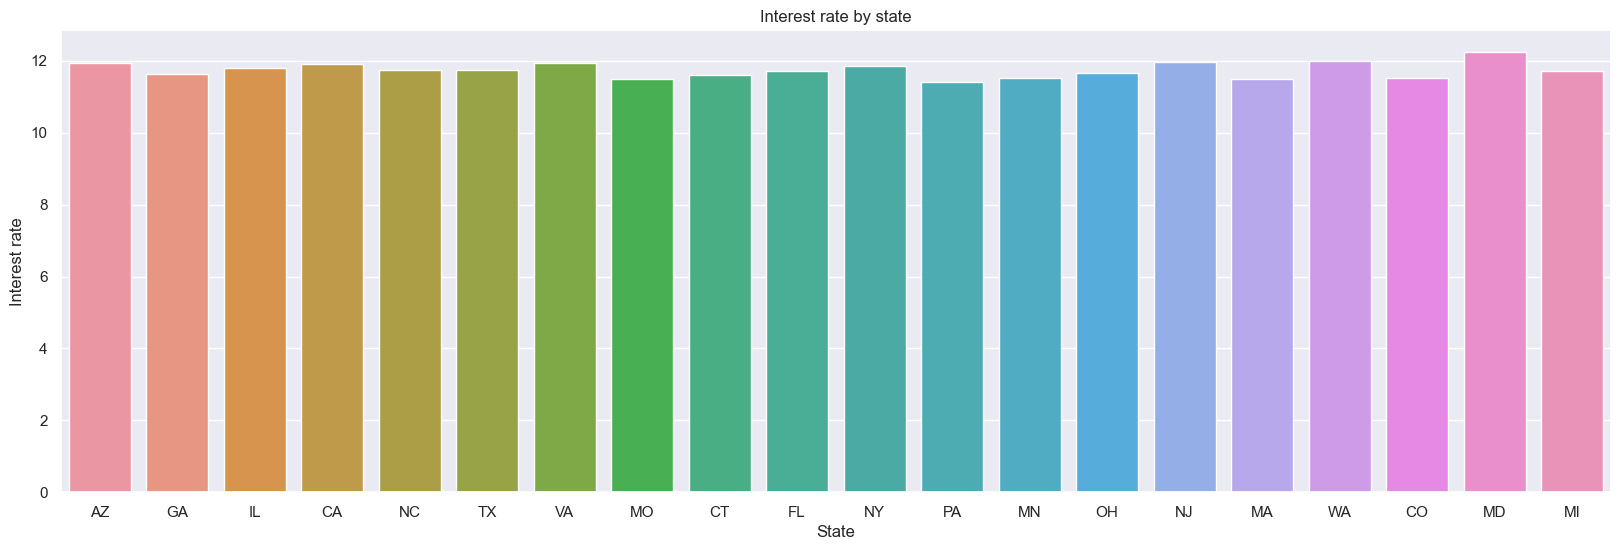

In [139]:
# interest rate by state
plt.figure(figsize=(20, 6))

loans_per_State = loans[['addr_state', 'int_rate_num']].copy()

# ignore states with less than 500 loans
loans_per_State = loans_per_State.groupby(['addr_state']).filter(lambda x: len(x) > 500)

sns.barplot(x='addr_state', y='int_rate_num', data=loans_per_State, errorbar=None)

plt.title('Interest rate by state')
plt.xlabel('State')
plt.ylabel('Interest rate')
plt.show()

### Default rate by public records (good impact)

pub_rec_bankruptcies
0.0    33317
1.0     1564
2.0        5
Name: count, dtype: int64


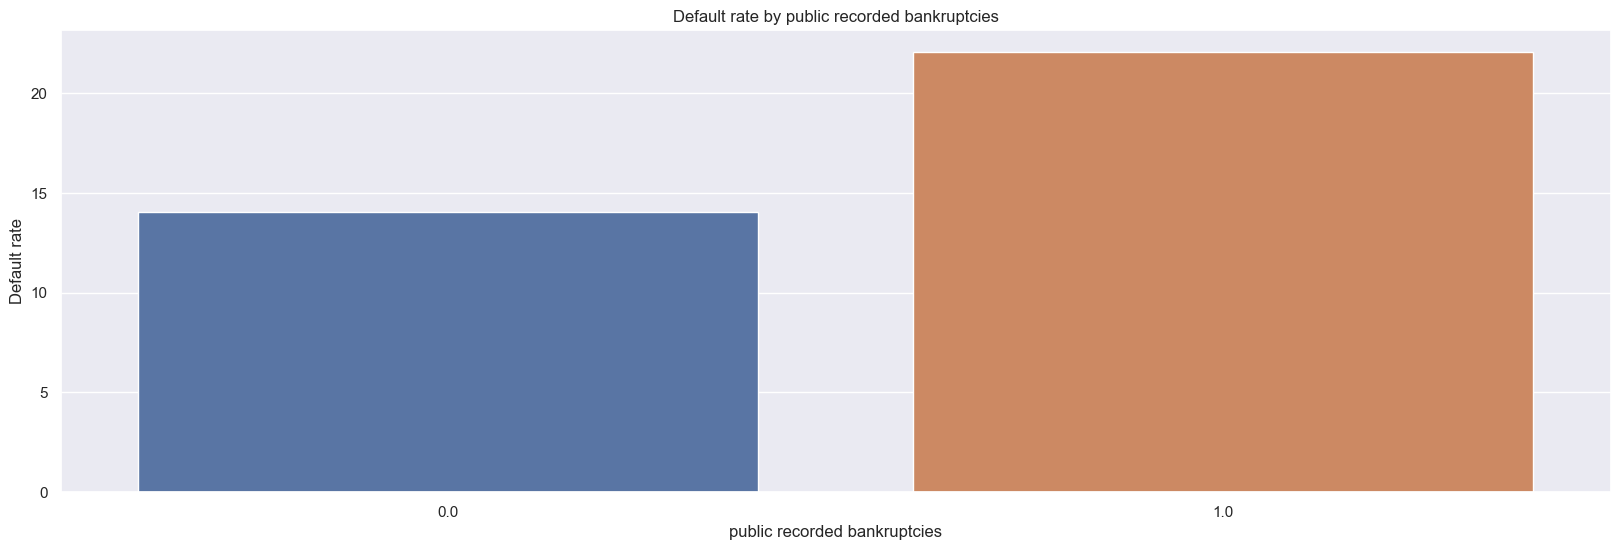

In [140]:
print(loans['pub_rec_bankruptcies'].value_counts())

# ignore 2 public recorded bankruptcies as they are very few
loans = loans[loans['pub_rec_bankruptcies'] != 2]

# draw default by pub_rec_bankruptcies
plt.figure(figsize=(20, 6))
default_rate = loans.groupby(['pub_rec_bankruptcies']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='pub_rec_bankruptcies', y='default', data=default_rate)
plt.title('Default rate by public recorded bankruptcies')
plt.xlabel('public recorded bankruptcies')
plt.ylabel('Default rate')
plt.show()


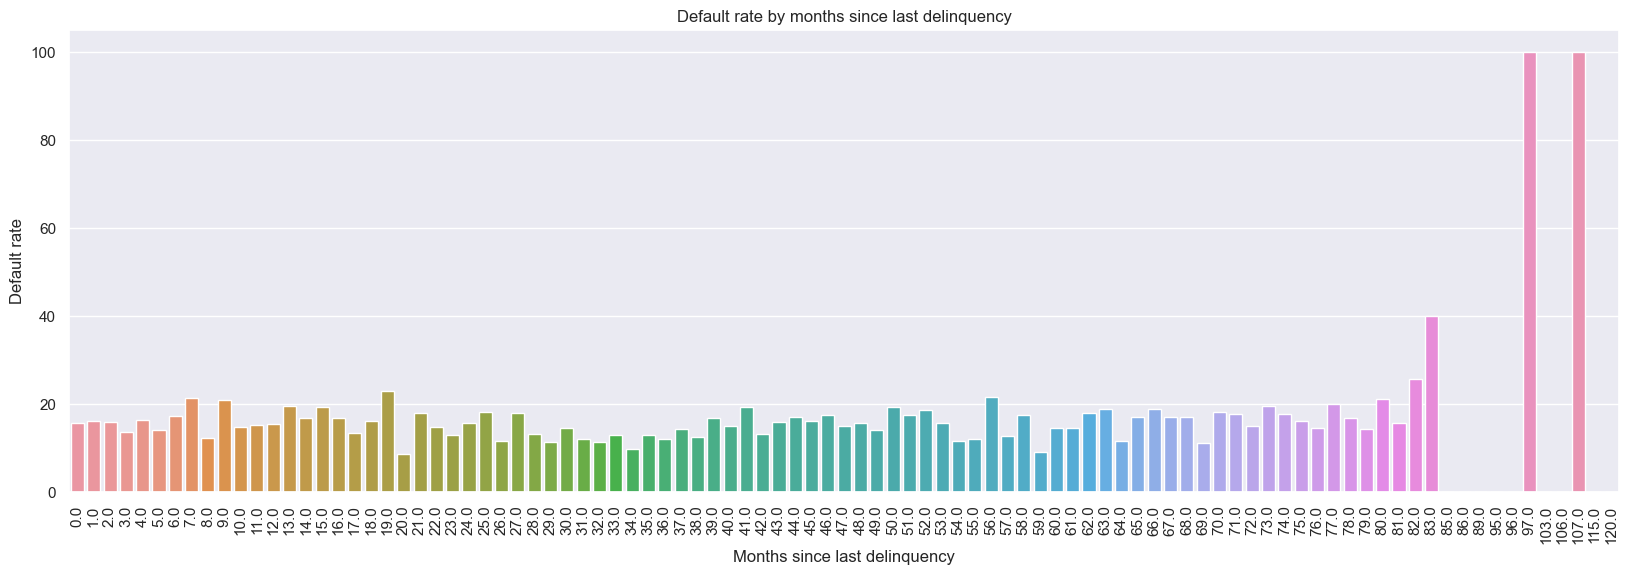

In [143]:
# draw default rate by mths_since_last_delinq (months since last delinquency) after binning
plt.figure(figsize=(20, 6))
default_rate = loans[['mths_since_last_delinq', 'default']].copy()

# bin the values
bin_edges = range(0, int(default_rate['mths_since_last_delinq'].max() + 12), 12)
default_rate['mths_since_last_delinq_bin'] = pd.cut(default_rate['mths_since_last_delinq'], bins=bin_edges, include_lowest=True, right=False)

# ignore bins that have less than 500 loans
# default_rate = default_rate.groupby(['mths_since_last_delinq']).filter(lambda x: len(x) > 500)

default_rate = default_rate.groupby(['mths_since_last_delinq']).agg({'default': 'mean'}).reset_index()

sns.barplot(x='mths_since_last_delinq', y='default', data=default_rate)
plt.title('Default rate by months since last delinquency')
plt.xticks(rotation=90)
plt.xlabel('Months since last delinquency')
plt.ylabel('Default rate')
plt.show()

mths_since_last_record
0.0      631
5.0        1
6.0        1
7.0        1
11.0       2
        ... 
117.0     41
118.0     34
119.0      9
120.0      1
129.0      1
Name: count, Length: 110, dtype: int64


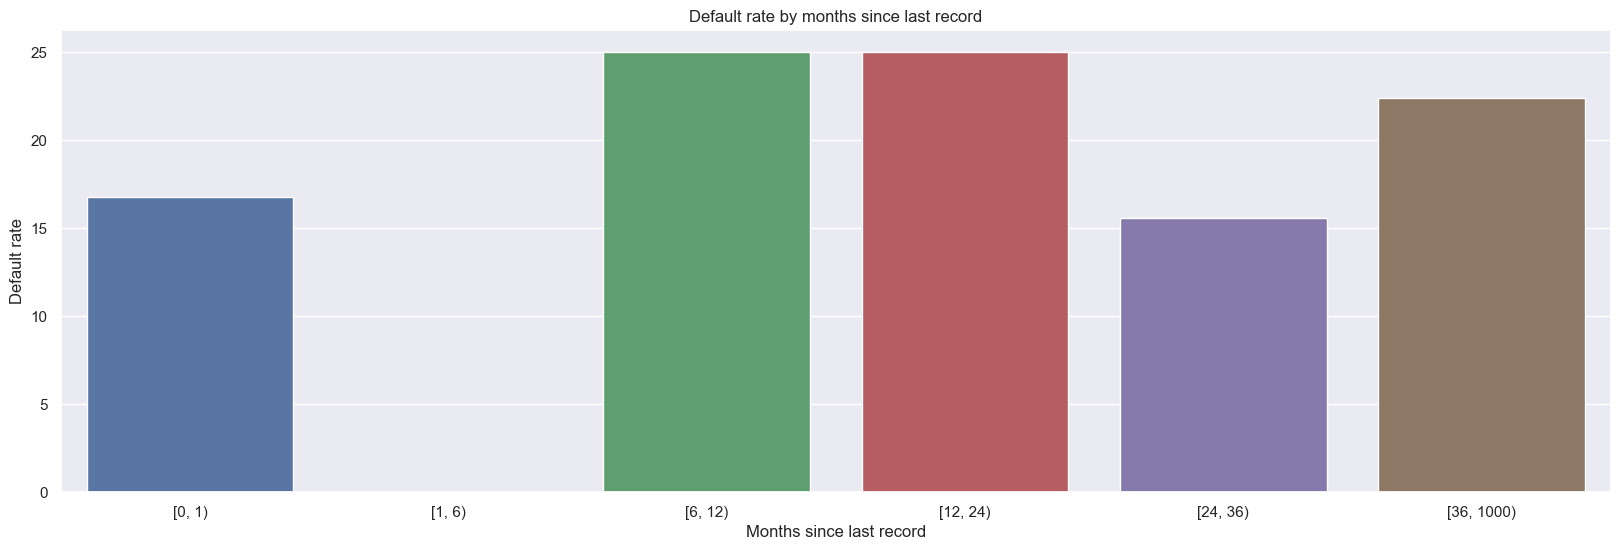

In [69]:
print(loans['mths_since_last_record'].value_counts().sort_index())
# draw default rate by mths_since_last_record (months since last record) after binning
plt.figure(figsize=(20, 6))
default_rate = loans[['mths_since_last_record', 'default']].copy()

# bin mths_since_last_record for 0 months, till last 6 months and more than 6 months
default_rate['mths_since_last_record_bin'] = pd.cut(default_rate['mths_since_last_record'], bins=[0, 1, 6, 12, 24, 36, 1000], include_lowest=True, right=False)

default_rate = default_rate.groupby(['mths_since_last_record_bin']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='mths_since_last_record_bin', y='default', data=default_rate)
plt.title('Default rate by months since last record')
plt.xlabel('Months since last record')
plt.ylabel('Default rate')
plt.show()

### Default rate by interest rate (not relevant)

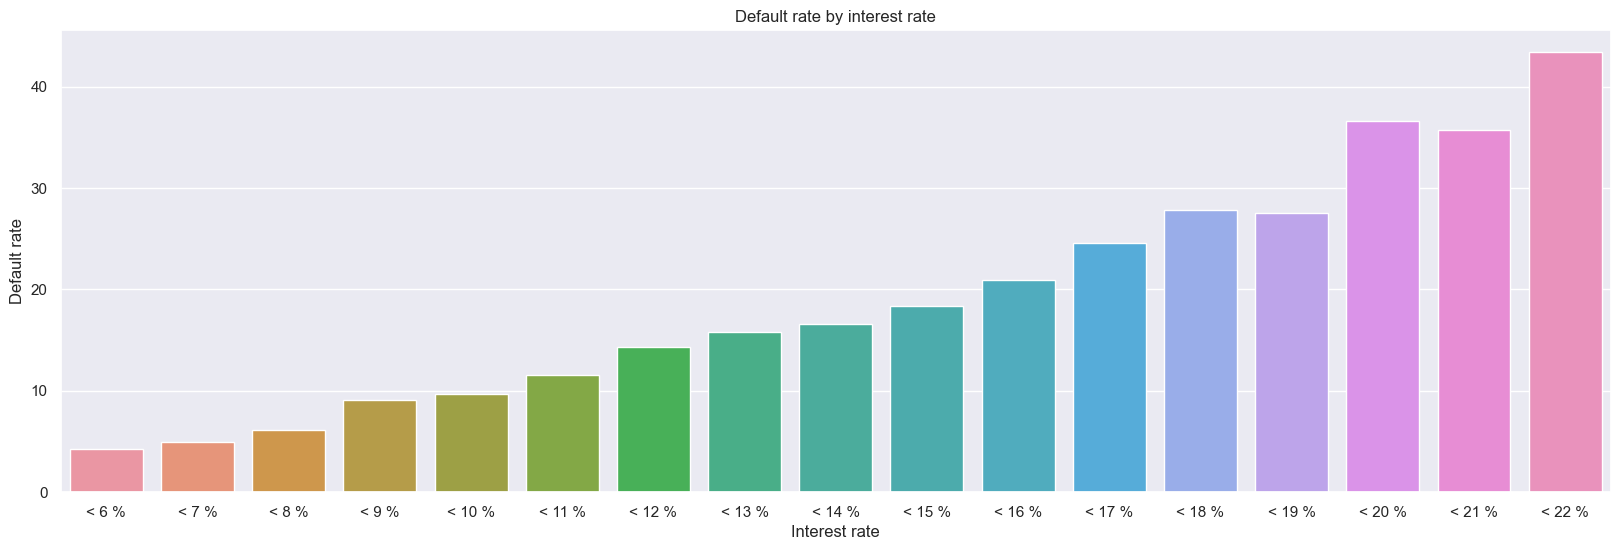

In [70]:
# draw default by binned interest rate
plt.figure(figsize=(20, 6))
default_rate_interest = loans[['int_rate_num', 'default']].copy()
# bin interest rate using intervals of 1% on column 'int_rate_num'
bin_edges = range(int(default_rate_interest['int_rate_num'].min()), int(default_rate_interest['int_rate_num'].max() + 1), 1)
default_rate_interest['int_rate_bin'] = pd.cut(default_rate_interest['int_rate_num'], bins=bin_edges, include_lowest=True, right=False)
default_rate_interest = default_rate_interest.groupby(['int_rate_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='int_rate_bin', y='default', data=default_rate_interest)
plt.title('Default rate by interest rate')
plt.xlabel('Interest rate')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_interest['int_rate_bin']])
plt.ylabel('Default rate')
plt.show()

### Default rate by loan amount (good impact)

Default rate is higher for higher loan amounts.

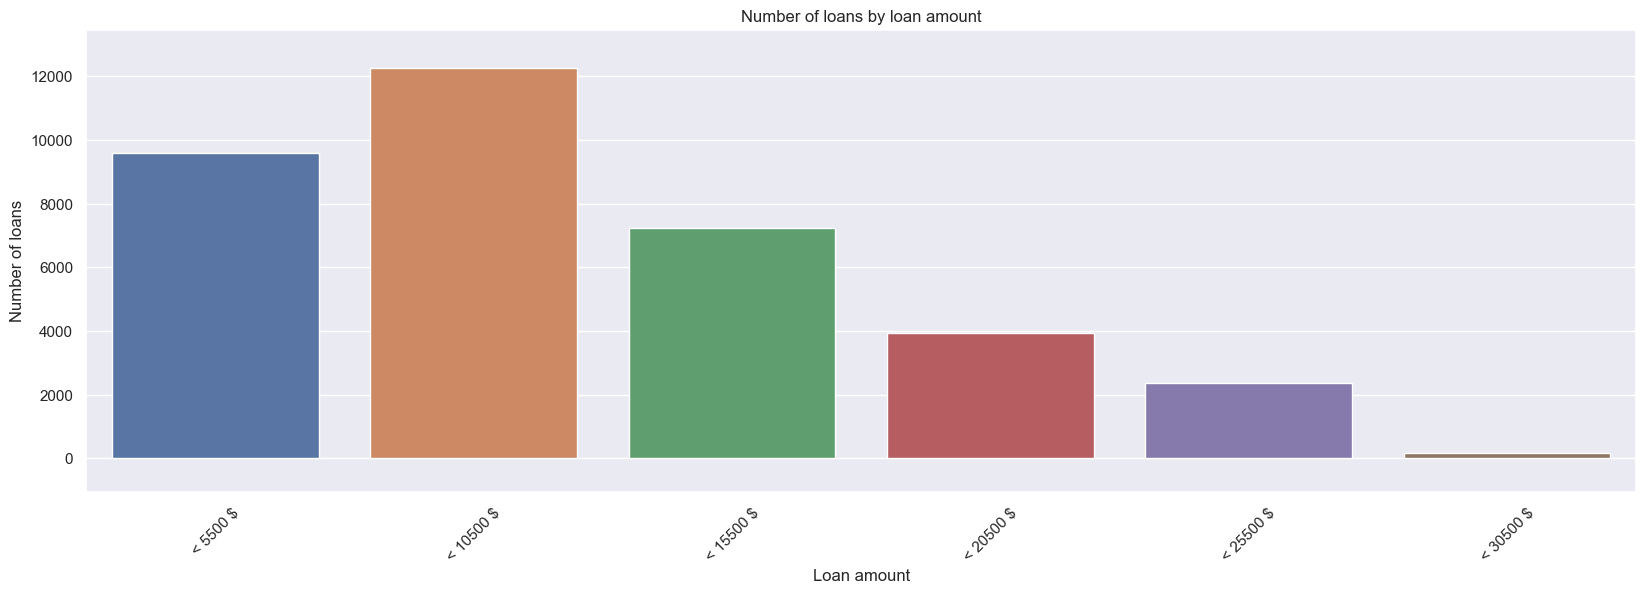

In [158]:
# plot number of loans by binned loan amount
plt.figure(figsize=(20, 6))
default_rate_loan_amount = loans[['loan_amnt', 'default']].copy()
# bin loan amount using intervals of 2000 on column 'loan_amnt'
bin_size = 5000
bin_edges = range(int(default_rate_loan_amount['loan_amnt'].min()), int(default_rate_loan_amount['loan_amnt'].max() + bin_size), bin_size)
default_rate_loan_amount['loan_amnt_bin'] = pd.cut(default_rate_loan_amount['loan_amnt'], bins=bin_edges, include_lowest=True, right=False)
default_rate_loan_amount = default_rate_loan_amount.groupby(['loan_amnt_bin']).agg({'default': 'count'}).reset_index()

bar_plot = sns.barplot(x='loan_amnt_bin', y='default', data=default_rate_loan_amount)

# Get the minimum and maximum values from your data
min_val = default_rate_loan_amount['default'].min()
max_val = default_rate_loan_amount['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Number of loans by loan amount')
plt.xlabel('Loan amount')
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_loan_amount['loan_amnt_bin']], rotation=45)
plt.ylabel('Number of loans')
plt.show()

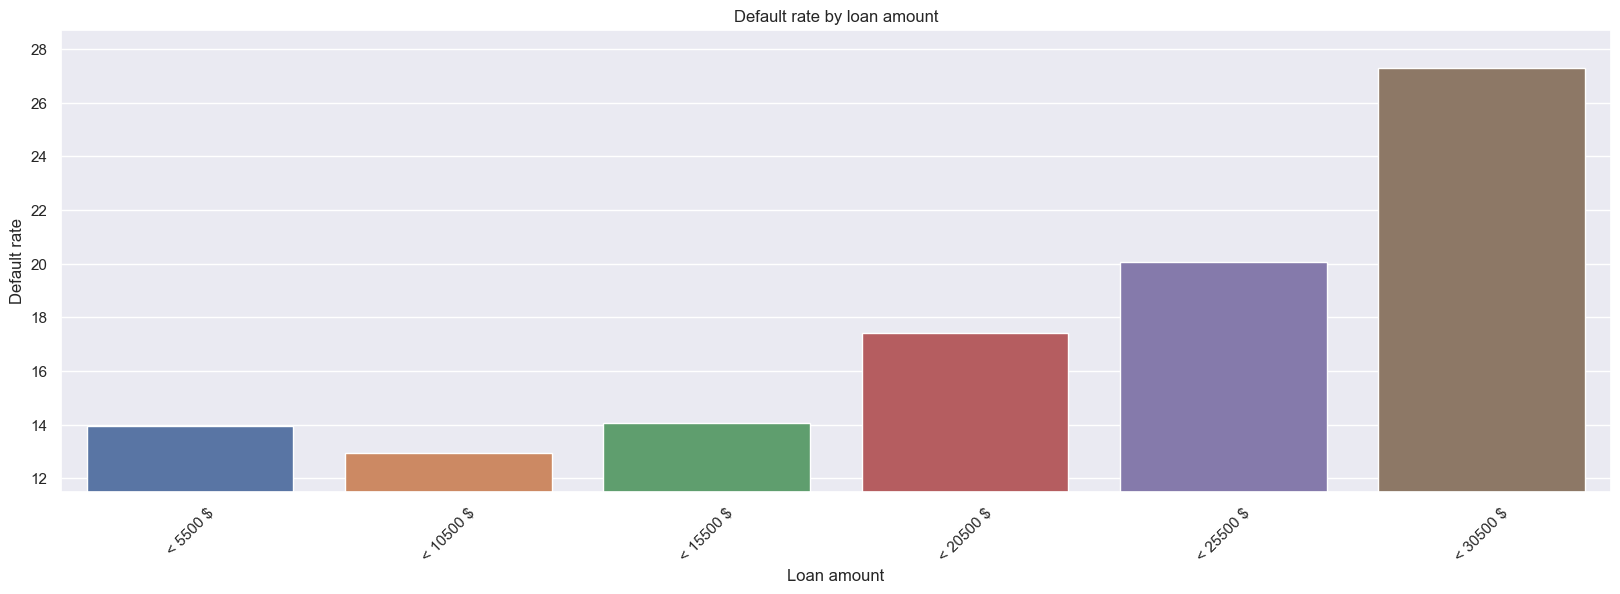

In [161]:
# plot default rate by binned loan amount
plt.figure(figsize=(20, 6))
default_rate_loan_amount = loans[['loan_amnt', 'default']].copy()
# bin loan amount using intervals of 2000 on column 'loan_amnt'
bin_size = 5000
bin_edges = range(int(default_rate_loan_amount['loan_amnt'].min()), int(default_rate_loan_amount['loan_amnt'].max() + bin_size), bin_size)

default_rate_loan_amount['loan_amnt_bin'] = pd.cut(default_rate_loan_amount['loan_amnt'], bins=bin_edges, include_lowest=True, right=False)
default_rate_loan_amount = default_rate_loan_amount.groupby(['loan_amnt_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='loan_amnt_bin', y='default', data=default_rate_loan_amount)

# Get the minimum and maximum values from your data
min_val = default_rate_loan_amount['default'].min()
max_val = default_rate_loan_amount['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by loan amount')
plt.xlabel('Loan amount')
bar_plot.set_xticklabels([f"< {str(interval.right)} $" for interval in default_rate_loan_amount['loan_amnt_bin']], rotation=45)
plt.ylabel('Default rate')
plt.show()

### Default rate by debt to income ratio (good impact)

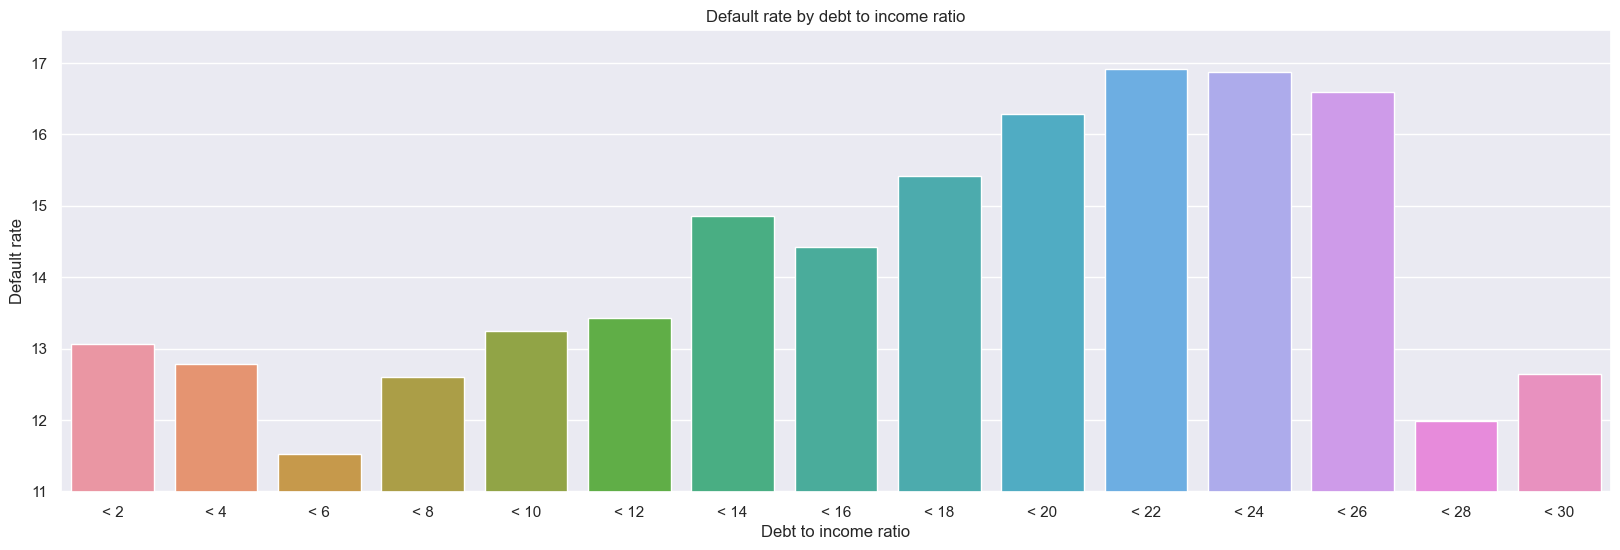

In [155]:
# plot default rate by dti
plt.figure(figsize=(20, 6))
default_rate_dti = loans[['dti', 'default']].copy()

# bin dti using intervals of 5 on column 'dti'
bin_edges = range(int(default_rate_dti['dti'].min()), int(default_rate_dti['dti'].max() + 2), 2)
default_rate_dti['dti_bin'] = pd.cut(default_rate_dti['dti'], bins=bin_edges, include_lowest=True, right=False)
default_rate_dti = default_rate_dti.groupby(['dti_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='dti_bin', y='default', data=default_rate_dti)

# Get the minimum and maximum values from your data
min_val = default_rate_dti['default'].min()
max_val = default_rate_dti['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by debt to income ratio')
plt.xlabel('Debt to income ratio')
bar_plot.set_xticklabels([f"< {str(interval.right)}" for interval in default_rate_dti['dti_bin']])
plt.ylabel('Default rate')
plt.show()

### Default rate by employment length (no impact)

Employment length has no impact on default rate.

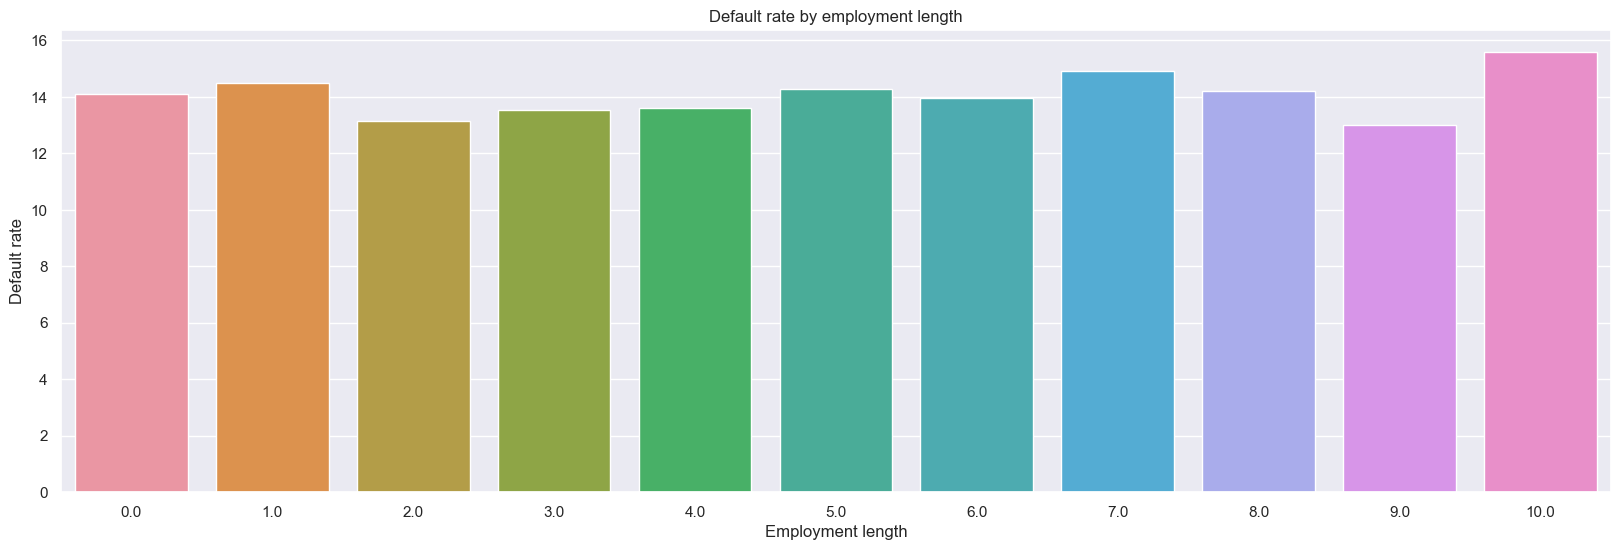

In [75]:
# plot default rate by emp_length_num
plt.figure(figsize=(20, 6))
default_rate_emp_length = loans[['emp_length_num', 'default']].copy()
default_rate_emp_length = default_rate_emp_length.groupby(['emp_length_num']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='emp_length_num', y='default', data=default_rate_emp_length)
plt.title('Default rate by employment length')
plt.xlabel('Employment length')
plt.ylabel('Default rate')
plt.show()

### Default rate by verification status (no impact)

Verification status of the lendee does not seem to have any impact on the default rate.

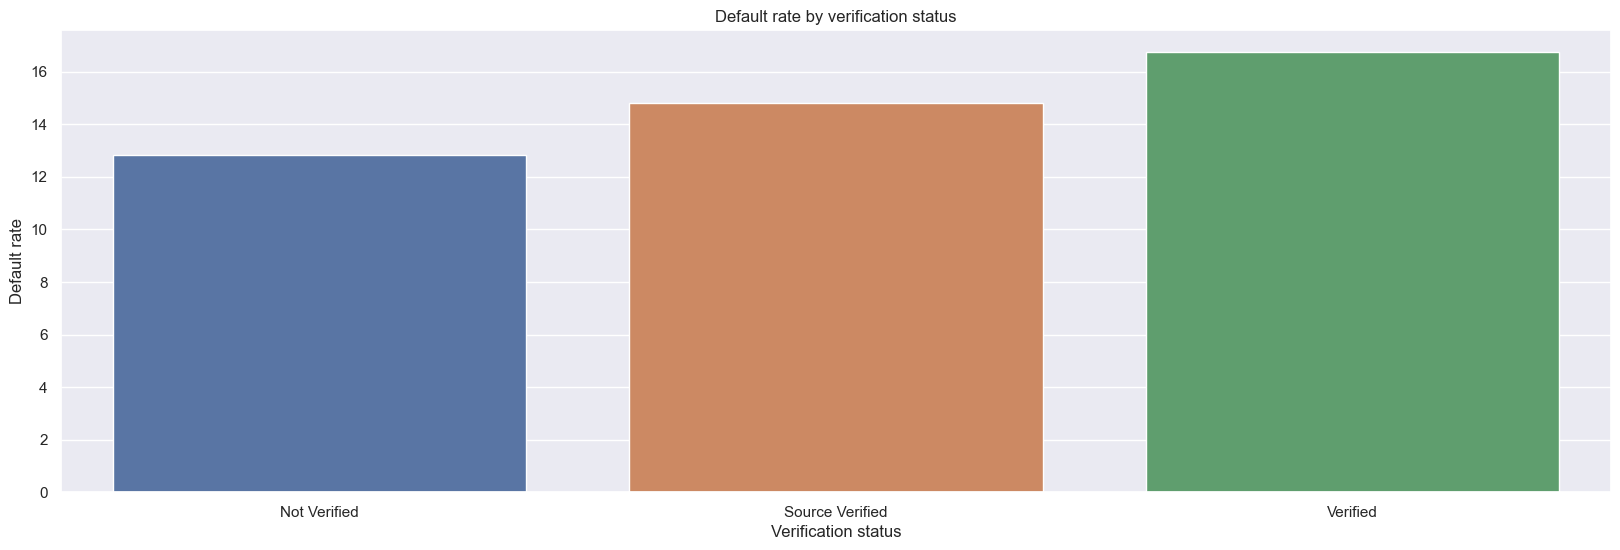

In [76]:
# plot default rate by verification_status
plt.figure(figsize=(20, 6))
default_rate_verification_status = loans[['verification_status', 'default']].copy()
default_rate_verification_status = default_rate_verification_status.groupby(['verification_status']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='verification_status', y='default', data=default_rate_verification_status)
plt.title('Default rate by verification status')
plt.xlabel('Verification status')
plt.ylabel('Default rate')
plt.show()

### Default rate by closed credit lines (good impact)

Default rate reduces with increase in closed credit lines, mening that people with more closed credit lines are more likely to pay back the loan due to their richer credit history

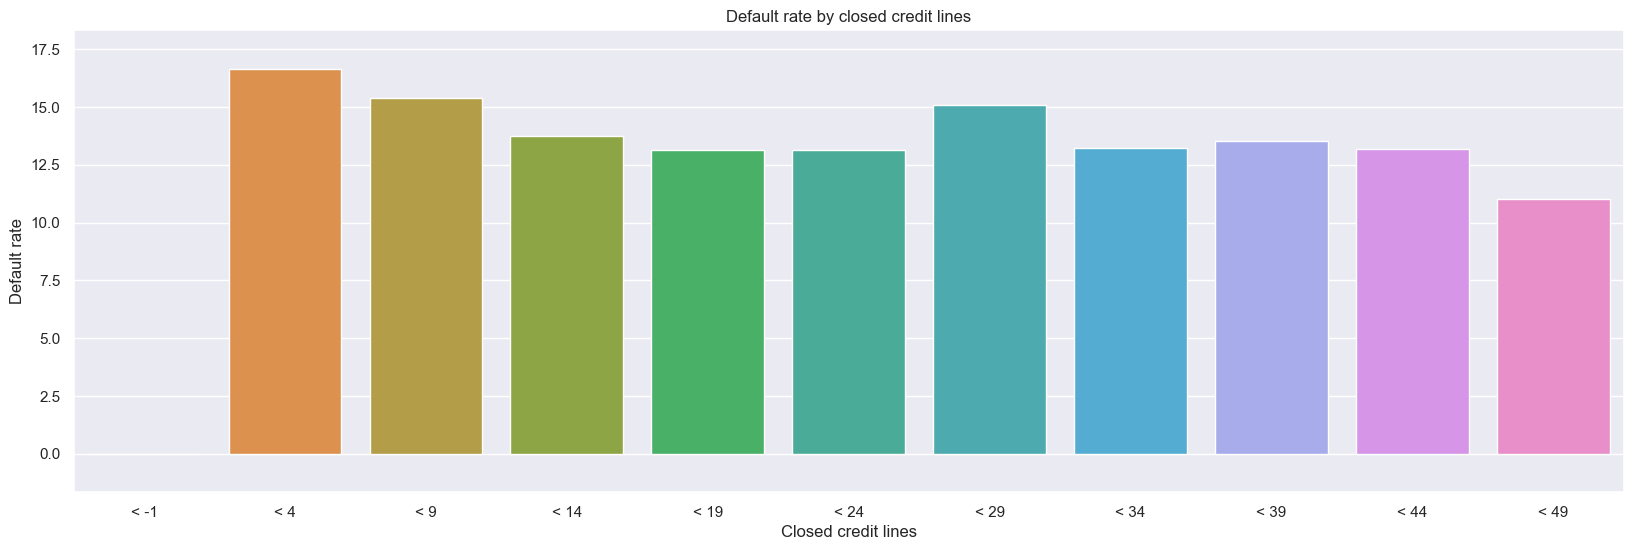

In [153]:
# create new column closed_acc
loans['closed_acc'] = loans['total_acc'] - loans['open_acc']

# plot default rate by binned closed credit lines
plt.figure(figsize=(20, 6))
default_rate_closed_acc = loans[['closed_acc', 'default']].copy()
# remove outliers for closed_acc
default_rate_closed_acc = default_rate_closed_acc[default_rate_closed_acc['closed_acc'] < 50]
# bin closed_acc using intervals of 5 on column 'closed_acc'
bin_size = 5
bin_edges = range(int(default_rate_closed_acc['closed_acc'].min()), int(default_rate_closed_acc['closed_acc'].max() + bin_size), bin_size)
default_rate_closed_acc['closed_acc_bin'] = pd.cut(default_rate_closed_acc['closed_acc'], bins=bin_edges, include_lowest=True, right=False)
default_rate_closed_acc = default_rate_closed_acc.groupby(['closed_acc_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='closed_acc_bin', y='default', data=default_rate_closed_acc)

# Get the minimum and maximum values from your data
min_val = default_rate_closed_acc['default'].min()
max_val = default_rate_closed_acc['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by closed credit lines')
plt.xlabel('Closed credit lines')
bar_plot.set_xticklabels([f"< {str(interval.right)}" for interval in default_rate_closed_acc['closed_acc_bin']])
plt.ylabel('Default rate')
plt.show()

### Default rate by revolving credit utilization (huge impact)

Default rate increases with increase in revolving credit utilization, meaning that people with higher credit utilization are more likely to default on the loan as they have much less margin for error

Number of loans is almost evenly distributed across the credit utilization range

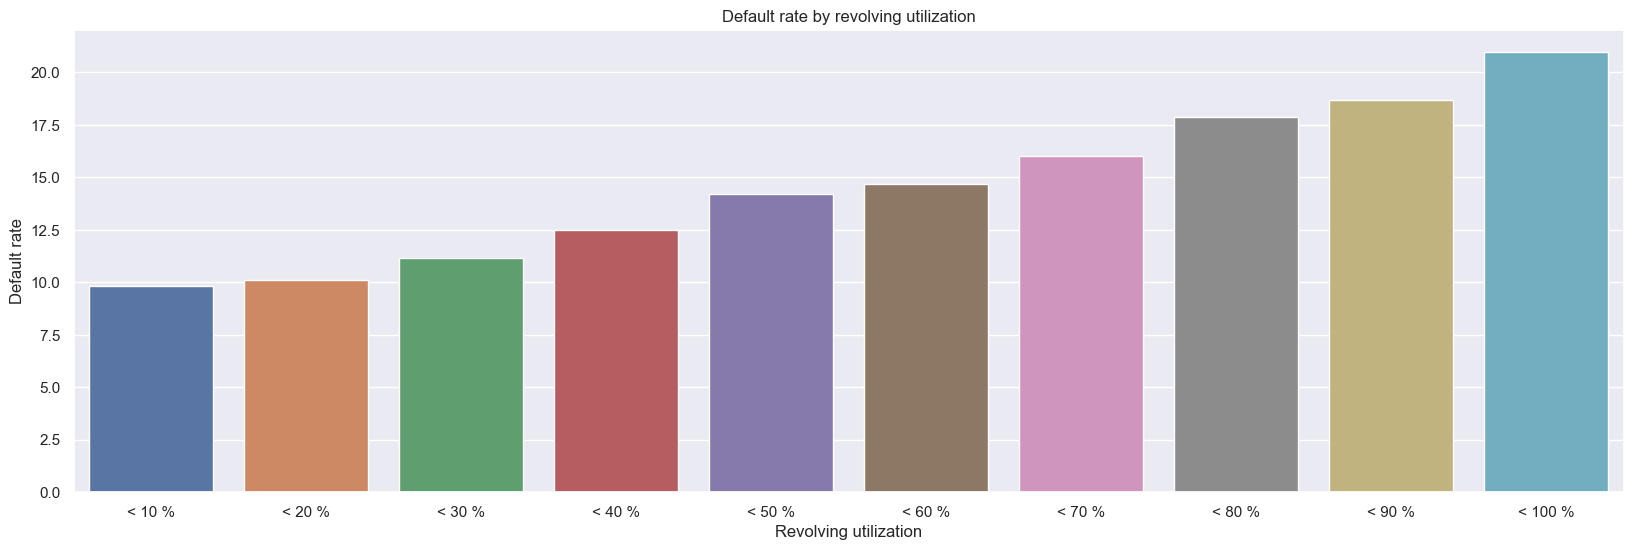

In [80]:
# plot default rate by binned revol_util_num
plt.figure(figsize=(20, 6))
default_rate_revol_util = loans[['revol_util_num', 'default']].copy()

# bin revol_util_num using intervals of 10 on column 'revol_util_num'
bin_size = 10
bin_edges = range(int(default_rate_revol_util['revol_util_num'].min()), int(default_rate_revol_util['revol_util_num'].max() + bin_size), bin_size)
default_rate_revol_util['revol_util_bin'] = pd.cut(default_rate_revol_util['revol_util_num'], bins=bin_edges, include_lowest=True, right=False)
default_rate_revol_util = default_rate_revol_util.groupby(['revol_util_bin']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='revol_util_bin', y='default', data=default_rate_revol_util)
plt.title('Default rate by revolving utilization')
plt.xlabel('Revolving utilization')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_revol_util['revol_util_bin']])
plt.ylabel('Default rate')
plt.show()

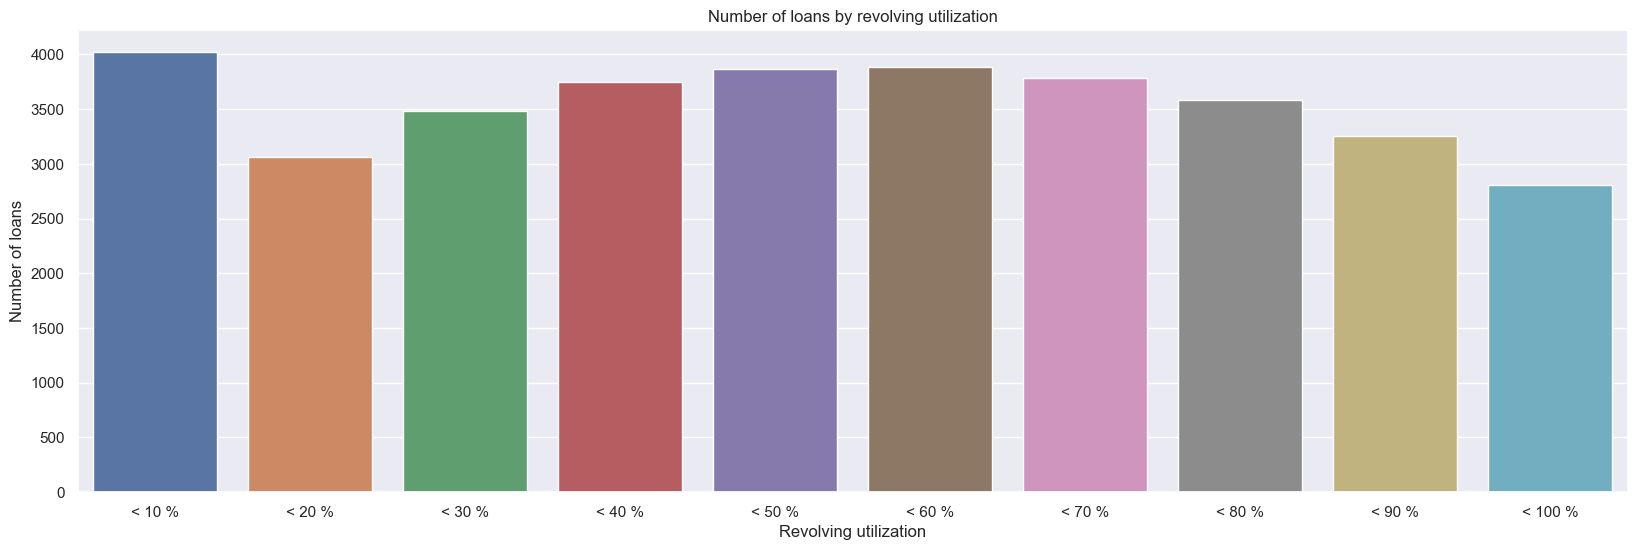

In [81]:
# plot number of loans by revol_util_num
plt.figure(figsize=(20, 6))
default_rate_revol_util = loans[['revol_util_num', 'default']].copy()
# remove outliers for revol_util_num
default_rate_revol_util = default_rate_revol_util[default_rate_revol_util['revol_util_num'] < 100]
# bin revol_util_num using intervals of 10 on column 'revol_util_num'
bin_size = 10
bin_edges = range(int(default_rate_revol_util['revol_util_num'].min()), int(default_rate_revol_util['revol_util_num'].max() + bin_size), bin_size)
default_rate_revol_util['revol_util_bin'] = pd.cut(default_rate_revol_util['revol_util_num'], bins=bin_edges, include_lowest=True, right=False)
default_rate_revol_util = default_rate_revol_util.groupby(['revol_util_bin']).agg({'default': 'count'}).reset_index()

bar_plot = sns.barplot(x='revol_util_bin', y='default', data=default_rate_revol_util)
plt.title('Number of loans by revolving utilization')
plt.xlabel('Revolving utilization')
bar_plot.set_xticklabels([f"< {str(interval.right)} %" for interval in default_rate_revol_util['revol_util_bin']])
plt.ylabel('Number of loans')
plt.show()

### Default rate by number of inquiries (good impact)

Default rate is much higher for people with more inquiries, this could be because they are looking for more loans and worsening their financial situation

inq_last_6mths
0    17345
1     9818
2     5170
3     2708
4      275
5      128
6       51
7       30
8       10
Name: count, dtype: int64


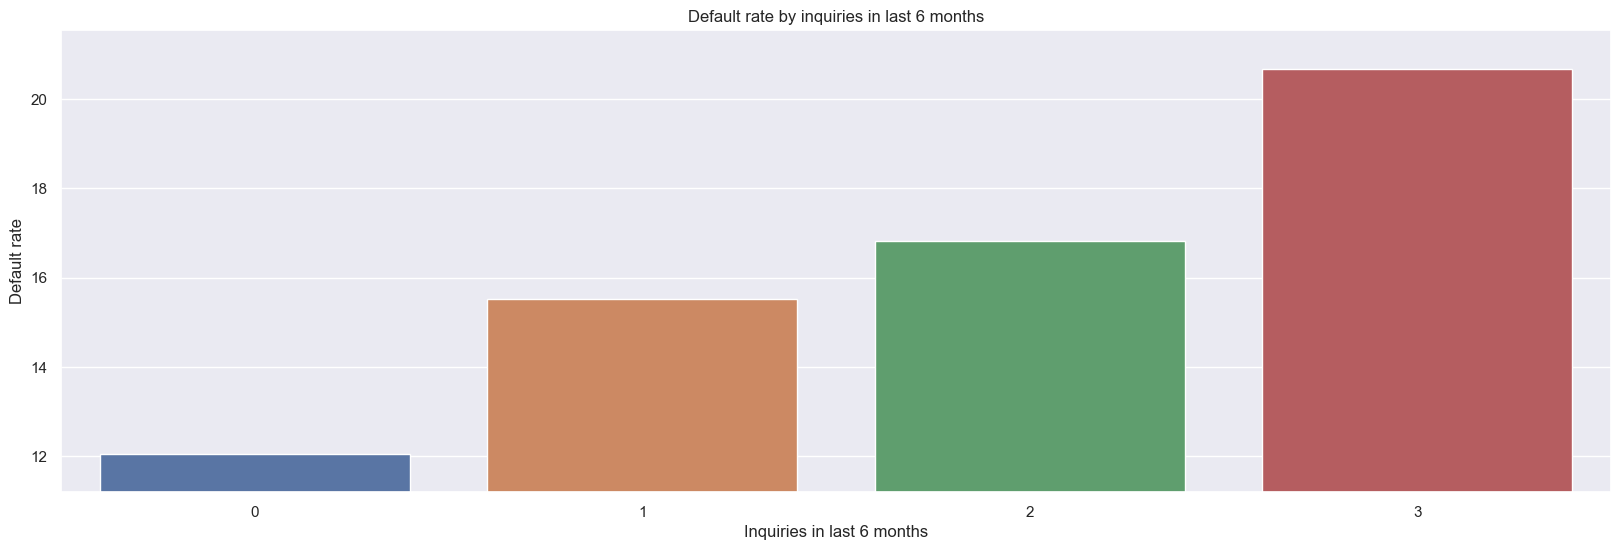

In [151]:
# plot default rate by inq_last_6mths
plt.figure(figsize=(20, 6))
default_rate_inq_last_6mths = loans[['inq_last_6mths', 'default']].copy()

print(loans['inq_last_6mths'].value_counts())

# remove outliers for inq_last_6mths, for values greater than or equal to 4 as they are very few
default_rate_inq_last_6mths = default_rate_inq_last_6mths[default_rate_inq_last_6mths['inq_last_6mths'] < 4]

default_rate_inq_last_6mths = default_rate_inq_last_6mths.groupby(['inq_last_6mths']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='inq_last_6mths', y='default', data=default_rate_inq_last_6mths)

# Get the minimum and maximum values from your data
min_val = default_rate_inq_last_6mths['default'].min()
max_val = default_rate_inq_last_6mths['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by inquiries in last 6 months')
plt.xlabel('Inquiries in last 6 months')
plt.ylabel('Default rate')
plt.show()


### Default rate by delinquencies for past 2 years (good impact)

Default rate increases with increase in delinquencies for past 2 years, meaning that people with more delinquencies are more likely to default on the loan as they have a history of not paying back their loans

delinq_2yrs
0     31723
1      2933
2       592
3       195
4        56
5        18
6        10
7         4
8         2
9         1
11        1
Name: count, dtype: int64


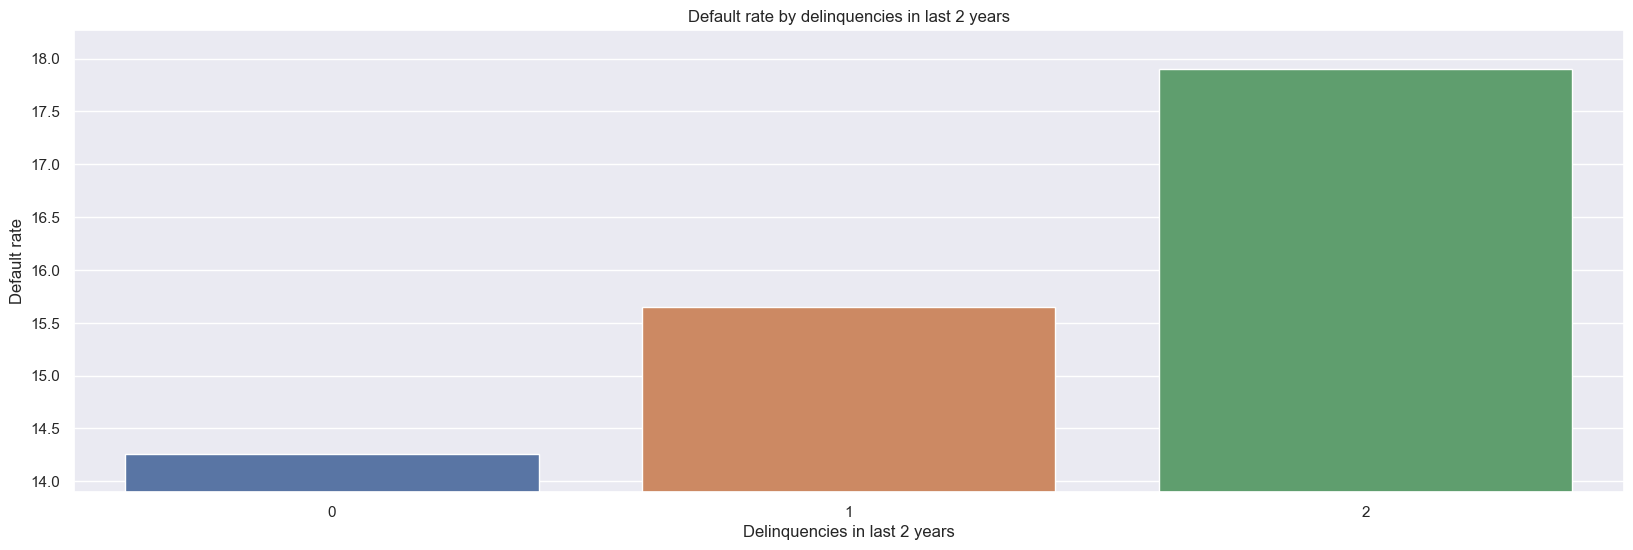

In [148]:
# plot default rate by delinq_2yrs
plt.figure(figsize=(20, 6))
default_rate_delinq_2yrs = loans[['delinq_2yrs', 'default']].copy()

print(default_rate_delinq_2yrs['delinq_2yrs'].value_counts())

# for values greater than or equal to 3 as they are very few records, so remove them
default_rate_delinq_2yrs = default_rate_delinq_2yrs[default_rate_delinq_2yrs['delinq_2yrs'] < 3]

default_rate_delinq_2yrs = default_rate_delinq_2yrs.groupby(['delinq_2yrs']).agg({'default': 'mean'}).reset_index()

bar_plot = sns.barplot(x='delinq_2yrs', y='default', data=default_rate_delinq_2yrs)

# Get the minimum and maximum values from your data
min_val = default_rate_delinq_2yrs['default'].min()
max_val = default_rate_delinq_2yrs['default'].max()

# Set the limits of y-axis to be slightly beyond the min and max
bar_plot.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))

plt.title('Default rate by delinquencies in last 2 years')
plt.xlabel('Delinquencies in last 2 years')
plt.ylabel('Default rate')
plt.show()